In [1]:
import os, sys, re, tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d
from shapely.geometry import LineString
import matplotlib.pyplot as plt
from pyemma import msm

def get_coul_vdW_lambdas(mdpfile):
    """Given an *.mdp file as input, extract the values of coul-lambdas and vdw-lambdas
    
    RETURNS
    coul_lambdas    - numpy array of coul-lambdas
    vdw_lambdas     - numpy array of vdw-lambdas
    
    NOTE: for some specific rpojects, the lambda=0 state is fully coupled,  and lambda=1 is fully uncoupled:         
              couple-lambda0         = vdw-q
              couple-lambda1         = none              
          That means that *first* the coulomb gets turned off, *then* the vdW:
          
    coul-lambdas         = 0.0 0.020 0.040 0.061 0.081 ... 0.979 1.0 1.000 1.000 1.000 1.000 ... 1.000 1.0
    vdw-lambdas          = 0.0 0.000 0.000 0.000 0.000 ... 0.000 0.0 0.020 0.040 0.061 0.081 ... 0.979 1.0
    """

    fin = open(mdpfile,'r')
    lines = fin.readlines()
    fin.close()

    restraint_lambdas, coul_lambdas, vdw_lambdas = None, None, None

    for line in lines:
        if line.count('coul-lambdas'):
            coul_string = line.split('=')[1].strip()
            coul_lambdas = np.array([float(s) for s in coul_string.split()])
        elif line.count('vdw-lambdas'):
            vdw_string = line.split('=')[1].strip()
            vdw_lambdas = np.array([float(s) for s in vdw_string.split()])
        elif line.count('restraint-lambdas'):
            restraint_string = line.split('=')[1].strip()
            restraint_lambdas = np.array([float(s) for s in restraint_string.split()])

    return coul_lambdas, vdw_lambdas, restraint_lambdas

def get_dhdl_data(dhdl_xvgfile, frames=0, verbose=False):

    r"""Read and parse the information in the dhdl file.
    
    RETURNS
    time_in_ps      - time in ps (1D np.array)
    thermo_states   - thermodynamic state indices (1D np.array)
    dhdl            - delta_Uij (np.array of shape (N,K))
                      where N is snapshots and K is number of thermodynamic states
    
    NOTES!!!
    ----> In ABSOLUTE binding free energy calcultions,
    
    time         ---> Column 0 is time in ps.                         
    thermo_index ---> Column 1 = @ s0 legend "Thermodynamic state"
                      Column 2 = @ s1 legend "Total Energy (kJ/mol)"
                      Column 3 = @ s2 legend "dH/d\\xl\\f{} fep-lambda = 0.0000"
                      Column 4 = @ s3 legend "dH/d\\xl\\f{} coul-lambda = 0.0000"
                      Column 5 = @ s4 legend "dH/d\\xl\\f{} vdw-lambda = 0.0000"
    dU_ij starts      Column 6 = @ s5 legend "\\xD\\f{}H \\xl\\f{} to (0.0000, 0.0000, 0.0000)"
                      Column 7 = @ s6 legend "\\xD\\f{}H \\xl\f{} to (0.0000, 0.0200, 0.0000)"
                      Column 8 = @ s7 legend "\\xD\\f{}H \\xl\\f{} to (0.0000, 0.0400, 0.0000)"
    
    
    ----> In RELATIVE binding free energy calcultions,
    time         ---> Column 0 is time in ps.                         
    thermo_index ---> Column 1 = @ s0 legend "Thermodynamic state"
                      Column 2 = @ s1 legend "Total Energy (kJ/mol)"
                      Column 3 = @ s2 legend "dH/d\xl\f{} fep-lambda = 0.0000"
    
    dU_ij starts ---> Column 4 = @ s3 legend "\xD\f{}H \xl\f{} to 0.0000
                      Column 5 = @ s4 legend "\xD\f{}H \xl\f{} to 0.0020
                      Column 6 = @ s5 legend "\xD\f{}H \xl\f{} to 0.0040
    """
    
    assert os.path.exists(dhdl_xvgfile)

    # Read and parse the file
    fin = open(dhdl_xvgfile,'r')
    lines = fin.readlines()
    fin.close()

    dhdl_column_start = None
    # Read to headers to find which column starts the dhdl data
    for line in lines:
        # Looking for line like this: "@ s5 legend "\xD\f{}H \xl\f{} to (0.0000, 0.0000, 0.0000)"
        # or Looking for line like this: "@ s3 legend "\xD\f{}H \xl\f{} to 0.0000"
        if line.count('"\\xD\\f{}H') > 0:
            dhdl_column_start = int(line.split(' ')[1].replace('s','')) + 1
            break
    if verbose:
        print('dhdl data starts at column:', dhdl_column_start)

    # Get rid of all the header lines
    i = 0
    while i < len(lines):
        if (lines[i][0] == '#') or (lines[i][0] == '@'):
            lines.pop(i)
        else:
            i+=1
            
    # find the correct number of entries from the first line
    ncols = len(lines[0].strip().split())

    time_in_ps, dhdl, thermo_states = [], [], []
    for line in lines:
        line_data_list = [float(s) for s in line.strip().split()]

        # Skip line if it doesn't have the correct number of entries (sometimes the I/O gets
        # cutoff when writing the dhdl.xvg in it corrupts the data)
        if len(line_data_list) == ncols:
            time_in_ps.append(line_data_list[0])
            thermo_states.append(line_data_list[1])
            dhdl.append(line_data_list[dhdl_column_start:])

    time_in_ps = np.array(time_in_ps)
    dhdl = np.array(dhdl)
    thermo_states = np.array([int(x) for x in thermo_states])
    
    np.save(f'{path}/dhdl.npy',dhdl)
    np.save(f'{path}/itraj.npy',thermo_states)
    np.save(f'{path}/timesteps.npy', time_in_ps)

    if frames:
        dhdl = dhdl[:frames]
        thermo_states = thermo_states[:frames]

    return thermo_states, dhdl


def estimate_sigmas(dhdl, thermo_states, use_states=0):
    """Using as input the Delta_U_ij energies from the dhdl array, 
    estimate the standard deviations P(U_{i-->i+1}) for neighboring ensembles.
    
    RETURNS
    sigmas   - a np.array() of standard deviations P(U_{i-->i+1}).
    """

    sigmas = []
    if use_states:
        nlambdas = len(use_states)
    else:
        use_states = range(np.shape(dhdl)[1])
    
    nlambdas = len(use_states)
    plt.figure(figsize=(12, 12))
    colors = plt.get_cmap('rainbow')(np.linspace(0,1,len(use_states)))
    Ps = []
    
    for j in range(nlambdas-1):

        # Computing forward dH/dl overlap
        plt.subplot(5,1,1)
        Ind_i = (thermo_states == use_states[j])
        delta_u_ij = dhdl[Ind_i, use_states[j+1]] # only for neighbored ensembles

        mu, sigma = stats.norm.fit(delta_u_ij)
        sigmas.append(sigma)
        
        delta_u_bins = np.arange(-100., 100., 0.2)
        counts, bin_edges = np.histogram(delta_u_ij, bins=delta_u_bins)
        counts = counts/counts.sum() # normalize
        bin_centers = (bin_edges[0:-1] + bin_edges[1:])/2.0
        
        if j == 0:
            plt.step(bin_centers, counts, color=colors[j], label='Fully Coupled')
        elif j == nlambdas-2:
            plt.step(bin_centers, counts, color=colors[j], label='Fully Decoupled')
        else:
            plt.step(bin_centers, counts, color=colors[j])
            
        plt.yticks([])
        plt.xlabel('$\Delta U_{i \\rightarrow i+1}$')
        plt.ylabel('Counts')
        plt.legend()
        plt.title(f'Forward dH/d$\lambda$ Overlap')

        # Computing reverse dH/dl overlap
        plt.subplot(5,1,2)
        Ind_j = (thermo_states == use_states[j+1])
        Ind_j[(int(len(thermo_states)/2)):] = False # take the last half of the trajectory
        delta_u_ji = dhdl[Ind_j, use_states[j]]

        counts, bin_edges = np.histogram(delta_u_ji, bins=delta_u_bins)
        counts = counts/counts.sum() # normalize
        bin_centers = (bin_edges[0:-1] + bin_edges[1:])/2.0

        plt.step(bin_centers, counts, color=colors[j]) 
        #, label='$\Delta u_{%d \\rightarrow %d} \sigma$=%.2f'%(j,j+1,sigma))
        # plt.xlabel('$\Delta u_{%d \\rightarrow %d}$'%(j, j+1))
        plt.yticks([])
        plt.xlabel('$\Delta U_{i \\rightarrow i-1}$')
        plt.ylabel('Counts')
        plt.title(f'Reverse dH/d$\lambda$ Overlap')

        plt.subplot(5,1,3)
        # determine forward & reverse acceptance probabilities 
        Pacc_ij, delta_f_ij_values = P_accept_vs_delta_f_ij(delta_u_ij)
        Pacc_ji, delta_f_ji_values = P_accept_vs_delta_f_ij(delta_u_ji)

        # finding intersection
        first_line = LineString(np.column_stack((delta_f_ij_values, Pacc_ij)))
        second_line = LineString(np.column_stack((delta_f_ij_values, np.flip(Pacc_ji, axis=None))))
        intersection = first_line.intersection(second_line)

        try: # appending all the intersections which are Pacc_(i,j)s
            Ps.append(intersection.xy[1][0])
        except Exception as e:
            Ps.append(None)
            
        # plotting
        plt.plot(delta_f_ij_values, Pacc_ij, zorder=1, color=colors[j])
        plt.plot(-delta_f_ji_values, Pacc_ji, zorder=2, color=colors[j])
        plt.scatter(intersection.xy[0], intersection.xy[1], marker='*', color='k', s=25, zorder=3)

        plt.xlabel('$\Delta U$')
        plt.ylabel('Acceptance Probability')
        plt.title('Intersection of $\Delta f_{i \\rightarrow j}$ and $\Delta f_{j \\rightarrow i}$')
    
    plt.subplot(5,1,4)
    plt.plot(range(len(Ps)), Ps, '.-', label=name)  # Ps are Pacc_(i,j)s
    plt.ylim(0,1)
    labels = ['%d \u2192 %d'%(i,i+1) for i in range(nlambdas-1)]
    plt.xticks(np.arange(len(labels)), labels, rotation=90)
    plt.ylabel(r'$P_{accept}$')
    plt.title(f'Acceptance Probabilities')
    plt.tight_layout()
    
    # compute forward and reverse MFPTs
    forward, reverse, X = [],[],[]
    plt.subplot(5,1,5)
    for i in range(10,101): #101
        ndx = int(len(thermo_states) * (i/100))
        # MSM with a unit of 500ps lagtime (dhdl save interval)
        M = msm.estimate_markov_model(thermo_states[:ndx], 1)
        forward.append(M.mfpt(min(use_states), max(use_states))/2000)
        reverse.append(M.mfpt(max(use_states), min(use_states))/2000)
        X.append(ndx/2000)
        
    mfpt = [forward[-1], reverse[-1]]
    plt.scatter(X, forward, s=8, color='b', label='Forward MFPT')
    plt.scatter(X, reverse, s=8, color='g', label='Reverse MFPT')
    plt.xlabel('Simulation Time (ns)')
    plt.ylabel('MFPT (ns)')
    plt.ylim(0,3)
    plt.legend()
    plt.suptitle(name)
    plt.tight_layout()
    
    if save_plots:
        plt.savefig(f'plots/{re.sub(" ","_",name)}.png', dpi=300)
    else:
        plt.show()
    plt.close()

    return np.array(sigmas), mfpt


def opt_lambdas(sigmas, cal_type, nsteps=1000000, tol=1e-9, alpha=2e-4, max_del_lambda=1e-4): 
    # cal_type = 'absolute'(having coul and vdw) or 'relative' (only having fep lambdas)
    # nsteps = 2500000         steps of steepest descent to perform
    # tol = 1e-9               stop if the lambdas dont change within this tolerance
    # alpha = 2e-4             gradient descent step size
    # max_del_lambda = 0.0001  the minimization step limited to this as a maximum change
    
    ### Lambda optimization
    dx = sigmas  # according to the equation (VAV: k is set to 1)

    x_values = np.cumsum(dx)  # convert to a list of x values of separated harmonic potentials
    x_values = np.array(np.concatenate([[0], x_values])) # add a zero corresponding to lambda0 = 0.0

    lambda_values = lambdas         #not inclduing the first one, lambda_0 

    x_observed = lambda_values      #not inclduing the first one, lambda_0
    y_observed = x_values
                

    #plt.figure(figsize=(12,6))
    #plt.subplot(1,2,1)
    #plt.plot(x_observed, y_observed, 'ro', label = 'data')
    ## plt.semilogy(x_observed, y_observed, 'ro', label = 'data')
    
    # check for degenerate ensembles (something is likely wrong if they exist)
    dupes = [i for i in range(1,len(y_observed)) if y_observed[i-1] == y_observed[i]]
    if dupes:
        print('Degenerate ensembles found! Check your data or delete them.')
        sys.exit()
        
    try:
        y_spl = UnivariateSpline(x_observed, y_observed, s=0, k=3)
        #y_spl = CubicSpline(x_observed, y_observed)#, s=0,k=4)  
    except Exception as e:
        print('Failed to create spline..', e)
        sys.exit()
        
    x_range = np.linspace(x_observed[0], x_observed[-1], 1000)
    y_spl_1d = y_spl.derivative(n=1)    #n=1 , means the first order derivative
    # y_spl_1d = y_spl(x_observed, 1)  # first derivative of Cubic spline

    #plt.figure(figsize=(12,6))
    
    #plt.subplot(1,2,1)
    #plt.plot(x_observed, y_observed, 'ro', label = 'data')
    ## plt.semilogy(x_observed, y_observed, 'ro', label = 'data')
    #plt.plot(x_range, y_spl(x_range), label="spline")   # for UnivariateSpline
    ## plt.plot(x_observed, y_spl(x_observed), label="spline") # for CubicSpline
    #plt.legend()
    #plt.xlabel('Lambda Values')
    #plt.ylabel('Variance')

    #plt.subplot(1,2,2)   #derivative plot   
    #plt.plot(x_range, y_spl_1d(x_range), '-')
    #plt.plot(x_observed, y_spl_1d(x_observed), '.')
    #plt.ylabel('Derivative of Variance wrt Lambda')
    #plt.tight_layout()
    #plt.show()
    #plt.close()
                
    # Let's try a steepest descent algorithm: run the algorithm some fixed number of steps, or until some tolerance is reached
    print_every = int(nsteps/10)
    nlambdas = len(lambda_values)
    old_lambdas = np.array(lambda_values)
    traj_lambdas = np.zeros( (nlambdas,nsteps) )
    
    for step in range(nsteps):
        # store the trajectory of lambdas
        traj_lambdas[:,step] = old_lambdas

        # perform a steepest descent step
        new_lambdas = np.zeros( old_lambdas.shape )
        del_lambdas = np.zeros( old_lambdas.shape )
        del_lambdas[0] = 0.0   # fix the \lambda = 0 endpoint
        del_lambdas[nlambdas-1] = 0.0  # fix the \lambda = 1 endpoint
                
        y_all = y_spl(old_lambdas)
        yh, yi, yj = y_all[0:nlambdas-2], y_all[1:nlambdas-1], y_all[2:nlambdas]
        del_lambdas[1:nlambdas-1] = -1.0*alpha*2.0*y_spl_1d(old_lambdas[1:nlambdas-1])*( 2.0*yi - yh - yj)
        if abs(np.max(del_lambdas)) > max_del_lambda:
            del_lambdas[1:nlambdas-1] = del_lambdas[1:nlambdas-1]*max_del_lambda/np.max(del_lambdas)
        new_lambdas = old_lambdas + del_lambdas

        # record the average change in the lambdas 
        del_lambdas = np.abs(old_lambdas - new_lambdas).mean()
        if step % print_every == 0:
            print('step', step, 'del_lambdas', del_lambdas)
        if del_lambdas < tol:
            print('Tolerance has been reached after %s steps.\n\
            del_lambdas = %s < tol = %s'%(step,del_lambdas,tol))
            break

        old_lambdas = new_lambdas
                

    # Plot the results
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    for i in range(nlambdas):
        plt.plot(range(step), traj_lambdas[i,0:step], '-')
    plt.xlabel('Steepest Descent Step')
    plt.ylabel('$\lambda$')

    plt.subplot(1,2,2)
    for i in range(nlambdas):
        plt.plot(range(step), y_spl(traj_lambdas[i,0:step]), '-')
    plt.xlabel('Steepest Descent Step')
    plt.ylabel('$\lambda$')
    plt.suptitle(f'Lambda Convergence of {name}')
    
    if save_plots:
        plt.savefig(f'plots/{re.sub(" ","_",name)}_lambda_traj.png', dpi=300)
    else:
        plt.show()
    plt.close()            

    plt.figure(figsize=(12,4))

    plt.subplot(2,1,1)
    plt.plot(x_range, y_spl(x_range), 'b-', label="Spline")
    plt.plot(lambda_values, y_spl(np.array(lambda_values)), 'r.', label="Pre-optimization Lambdas")
    for value in lambda_values:
        plt.plot([value, value], [0, y_spl(value)], 'r-')
    plt.legend()
    plt.xlabel('$\lambda$')
    plt.yticks([])

    plt.subplot(2,1,2)
    plt.plot(x_range, y_spl(x_range), 'b-', label="Spline")
    plt.plot(new_lambdas, y_spl(new_lambdas), 'g.', label="Post-optimization Lambdas")
    for value in new_lambdas:
        plt.plot([value, value], [0, y_spl(value)], 'g-')
    plt.legend()
    plt.xlabel('$\lambda$')
    plt.yticks([])
    plt.suptitle(f'{name} Optimization of Lambda-Spacing')
    plt.tight_layout()
    
    if save_plots:
        plt.savefig(f'plots/{re.sub(" ","_",name)}_lambda_spacing.png', dpi=300)
    else:
        plt.show()
    plt.close()   
                
    if cal_type == 'absolute':
        # Finally, we transform the [0,2] coul+vdW interval back to separate coul_lambdas and vdw_lambdas
        new_rest_lambdas = np.minimum(new_lambdas, np.ones(new_lambdas.shape))
        new_coul_lambdas  = np.maximum(new_lambdas, np.ones(new_lambdas.shape)) - 1
        new_vdw_lambdas  = np.maximum([x-1 for x in new_coul_lambdas], np.zeros(new_lambdas.shape))
        new_coul_lambdas = np.minimum(new_coul_lambdas, np.ones(new_lambdas.shape))
        
        # print out the new lambdas as if they were in an mdp file
        outstring = 'restraint-lambdas    = ' + " ".join(['%1.4f'%lam for lam in new_rest_lambdas])
        outstring += '\ncoul-lambdas    = ' + " ".join(['%1.4f'%lam for lam in new_coul_lambdas])
        outstring += '\nvdw-lambdas     = ' + " ".join(['%1.4f'%lam for lam in new_vdw_lambdas]) +'\n'
        print(outstring)
        with open(f'{path}/lambdas.txt', 'w') as f:
            f.write(outstring)
    
    if cal_type == 'relative':
        # finally, print out new fep-lambdas
        outstring = 'fep_lambdas               =' + " ".join(['%1.4f'%lam for lam in new_lambdas])
        print(outstring)

    return new_coul_lambdas, new_vdw_lambdas, new_rest_lambdas

def P_accept_vs_delta_f_ij(delta_u_ij, delta_f_ij_range = (-100., 100., 0.5)):
    """Computes the average metropolis acceptance probability
    
        P_acc = min[ 1, exp(-(delta_u_ij + delta_f_ij))]
        
    for the specified range of delta_f_ij.
        
    INPUT
    delta_u_ij         - np.array() of sampled delta_u_ij values
    
    OPTIONS
    delta_f_ij_range   - tuple of min, max, and step in units kT
    
    RETURNS
    Pacc               - np.array() of acceptance probabilities 
    delta_f_ij_values  - np.array() of values where Pacc was evaluated
    """
    
    delta_f_ij_min  = delta_f_ij_range[0]
    delta_f_ij_max  = delta_f_ij_range[1] 
    delta_f_ij_step = delta_f_ij_range[2]
    
    delta_f_ij_values = np.arange(delta_f_ij_min, delta_f_ij_max, delta_f_ij_step)
    Pacc = np.zeros(delta_f_ij_values.shape)
    
    for i in range(delta_f_ij_values.shape[0]):
        delta_f_ij = delta_f_ij_values[i]
        Pacc[i] = np.mean( np.fmin(np.ones(delta_u_ij.shape), np.exp(-1.0*(delta_u_ij-delta_f_ij))) )
    
    return Pacc, delta_f_ij_values

################### Processing RL/pre-opt/RUN0 ###################


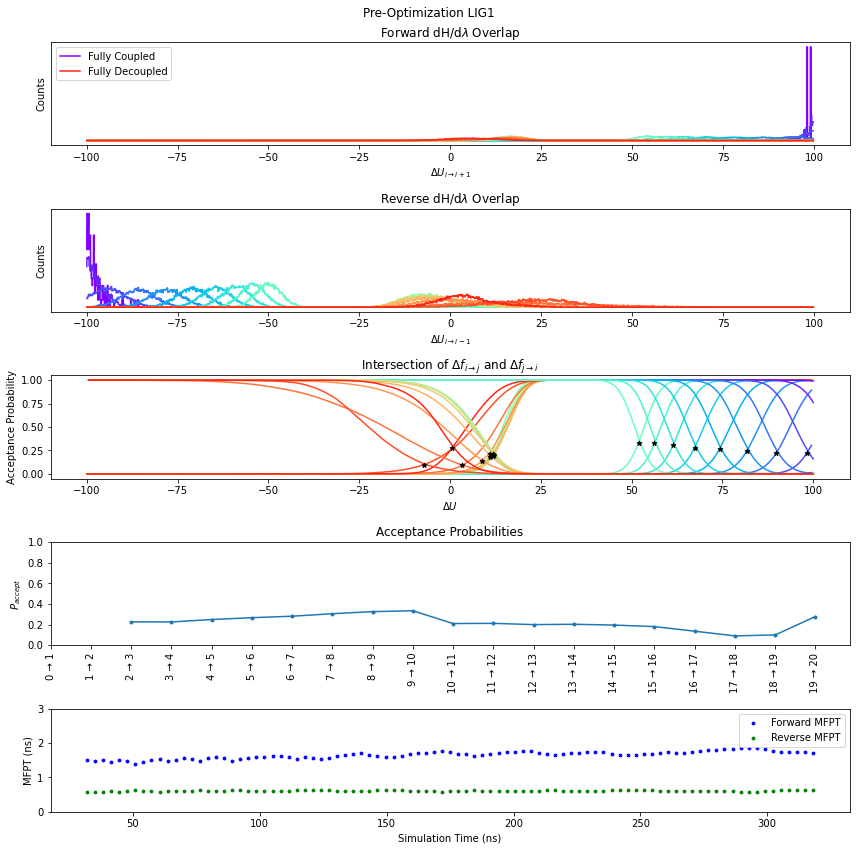

step 0 del_lambdas 1.4119366702406802e-05
Tolerance has been reached after 23955 steps.
            del_lambdas = 9.998351353195695e-14 < tol = 1e-13


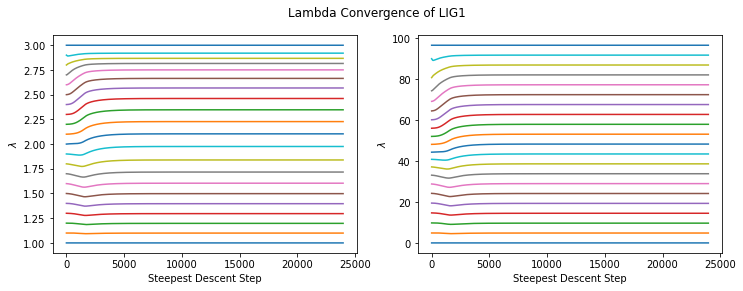

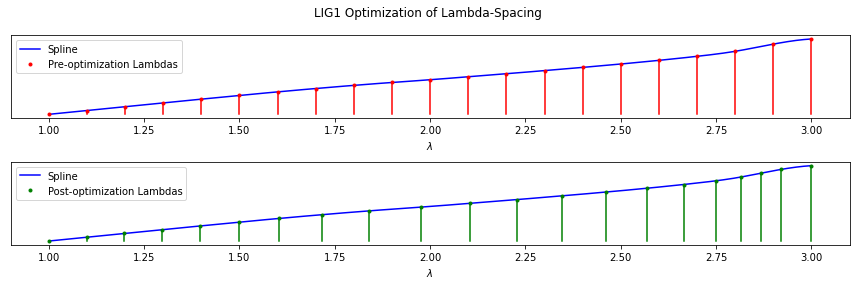

restraint-lambdas    = 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
coul-lambdas    = 0.0000 0.0995 0.1978 0.2964 0.3970 0.4986 0.6042 0.7170 0.8394 0.9757 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
vdw-lambdas     = 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.1036 0.2275 0.3469 0.4612 0.5676 0.6645 0.7508 0.8157 0.8674 0.9199 1.0000

################### Processing RL/pre-opt/RUN3 ###################


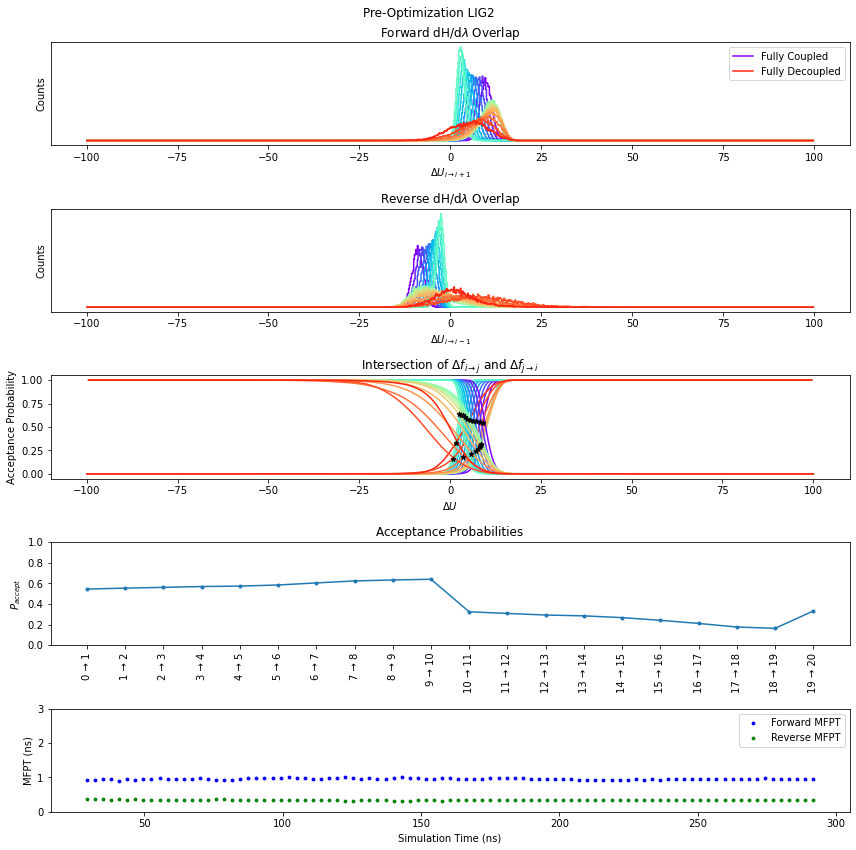

step 0 del_lambdas 1.9012782170149545e-05
Tolerance has been reached after 84474 steps.
            del_lambdas = 9.999408708457243e-14 < tol = 1e-13


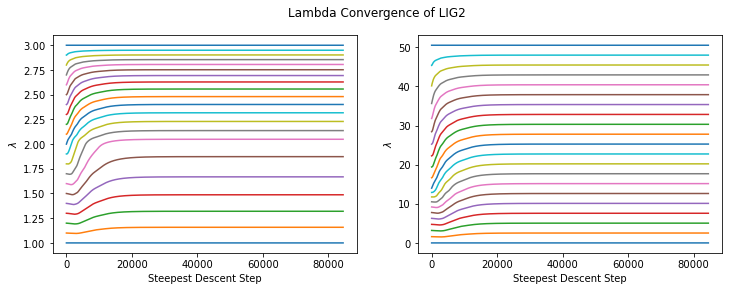

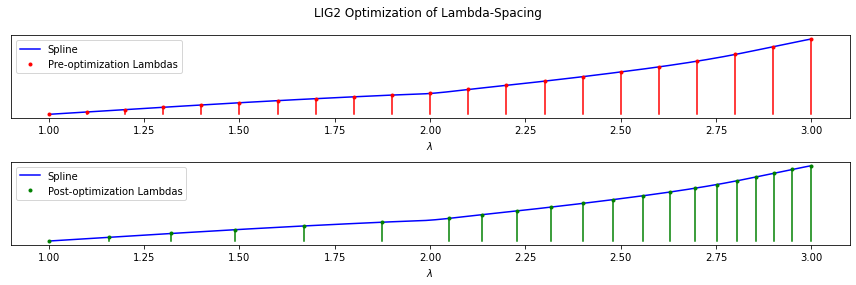

restraint-lambdas    = 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
coul-lambdas    = 0.0000 0.1581 0.3202 0.4870 0.6684 0.8728 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
vdw-lambdas     = 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0487 0.1364 0.2290 0.3167 0.4007 0.4805 0.5570 0.6285 0.6934 0.7522 0.8055 0.8545 0.9018 0.9495 1.0000

################### Processing RL/pre-opt/RUN4 ###################


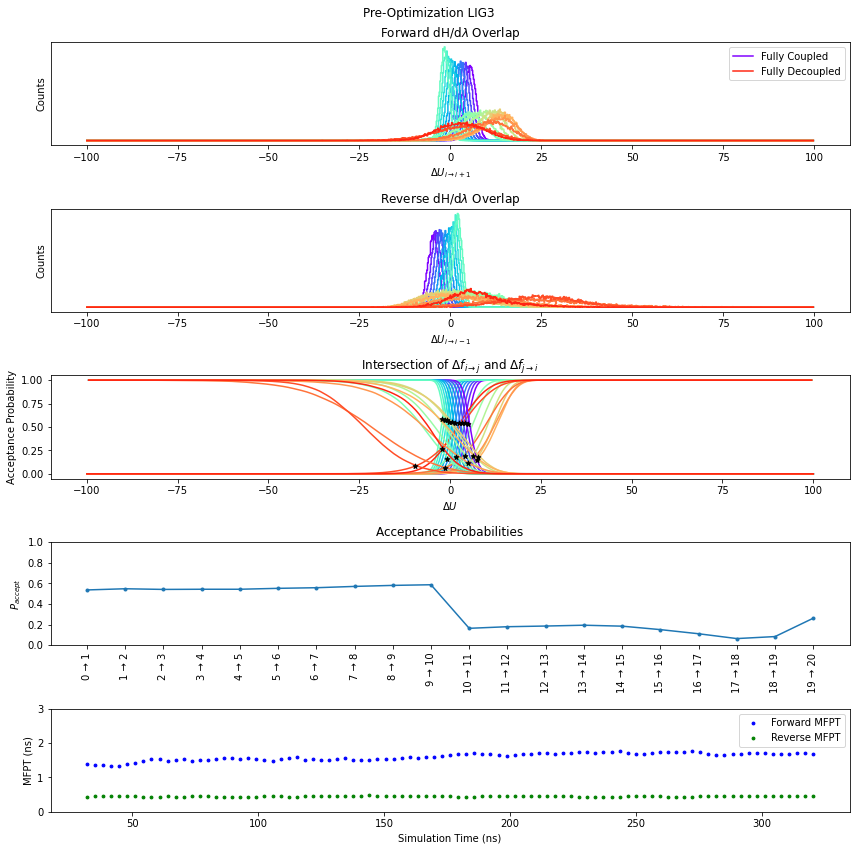

step 0 del_lambdas 1.942030375345376e-05
Tolerance has been reached after 89948 steps.
            del_lambdas = 9.999408708457243e-14 < tol = 1e-13


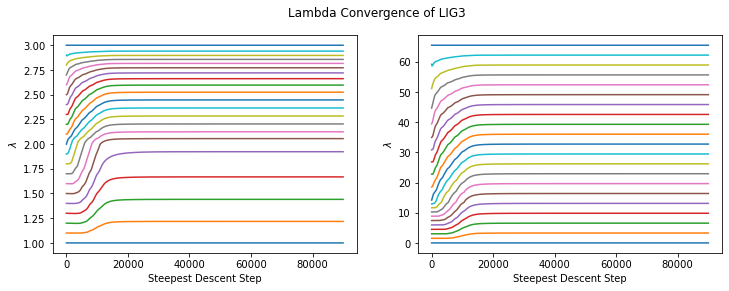

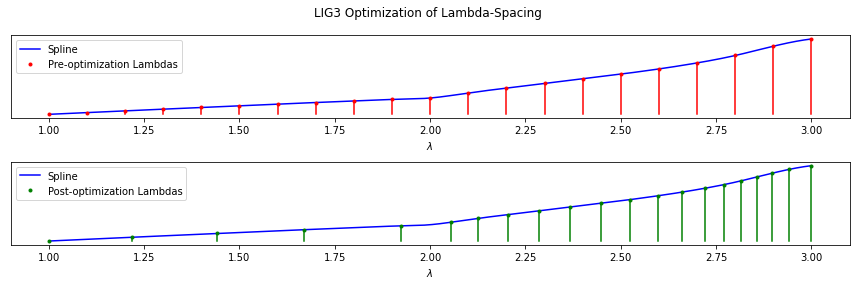

restraint-lambdas    = 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
coul-lambdas    = 0.0000 0.2176 0.4407 0.6680 0.9228 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
vdw-lambdas     = 0.0000 0.0000 0.0000 0.0000 0.0000 0.0553 0.1242 0.2037 0.2842 0.3655 0.4469 0.5249 0.5968 0.6617 0.7202 0.7719 0.8164 0.8568 0.8968 0.9407 1.0000

################### Processing RL/pre-opt/RUN5 ###################


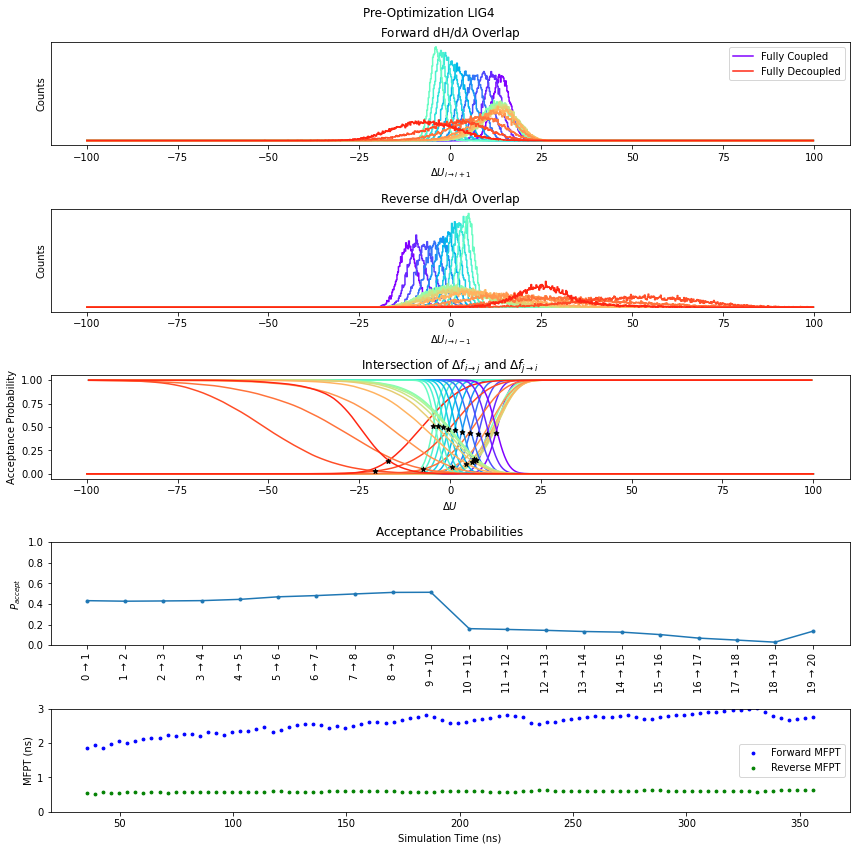

step 0 del_lambdas 1.5745916086498535e-05
Tolerance has been reached after 43235 steps.
            del_lambdas = 9.997293997934148e-14 < tol = 1e-13


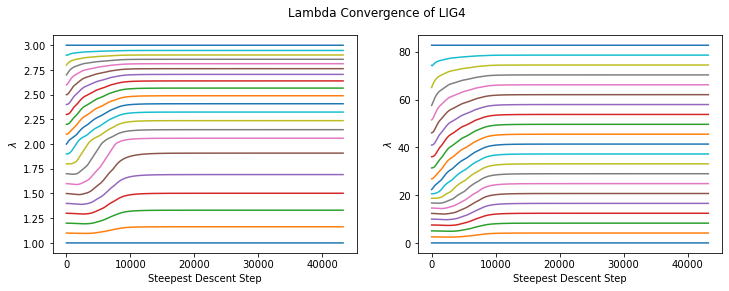

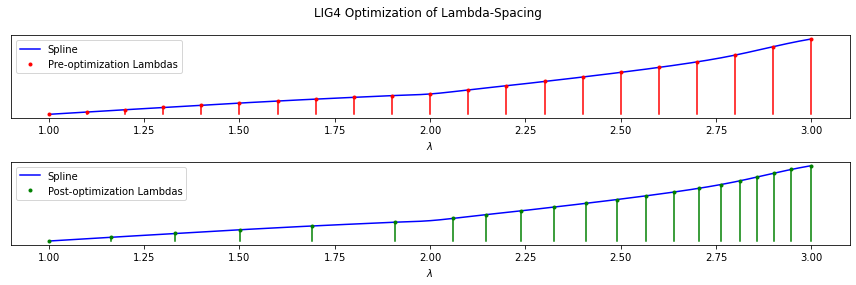

restraint-lambdas    = 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
coul-lambdas    = 0.0000 0.1635 0.3311 0.5024 0.6914 0.9085 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
vdw-lambdas     = 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0593 0.1457 0.2373 0.3240 0.4082 0.4891 0.5665 0.6392 0.7051 0.7630 0.8131 0.8580 0.9016 0.9472 1.0000

################### Processing RL/pre-opt/RUN6 ###################


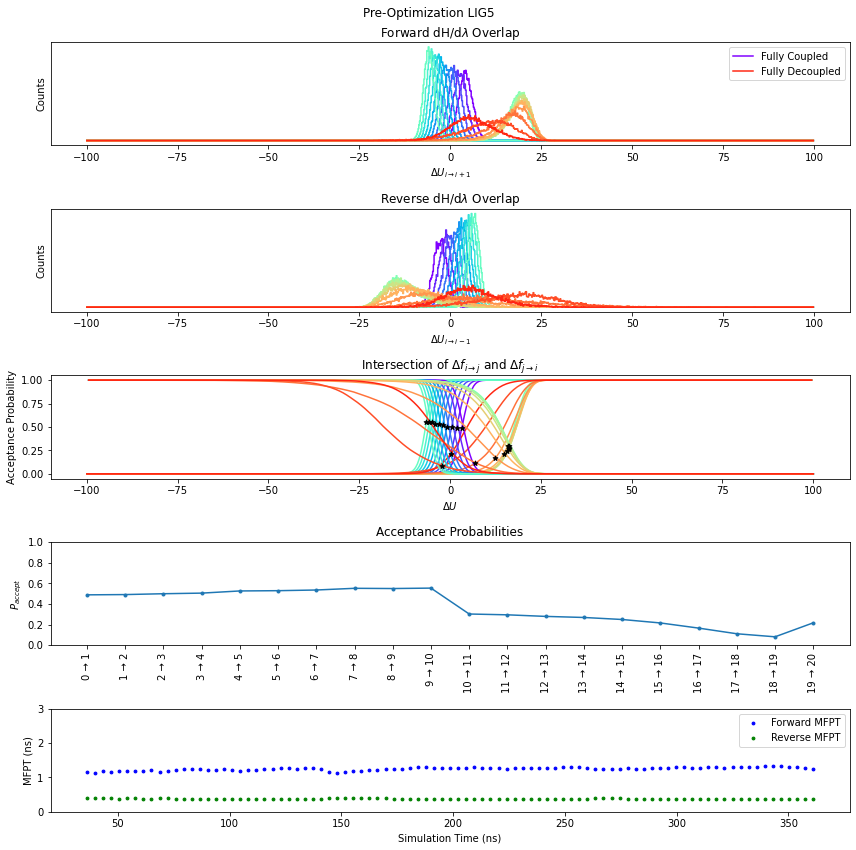

step 0 del_lambdas 1.6375803799576854e-05
Tolerance has been reached after 61874 steps.
            del_lambdas = 9.997293997934148e-14 < tol = 1e-13


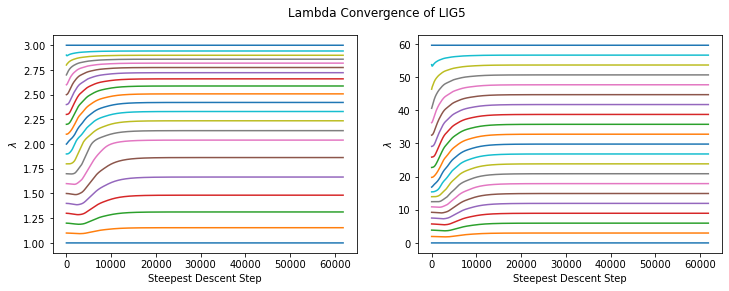

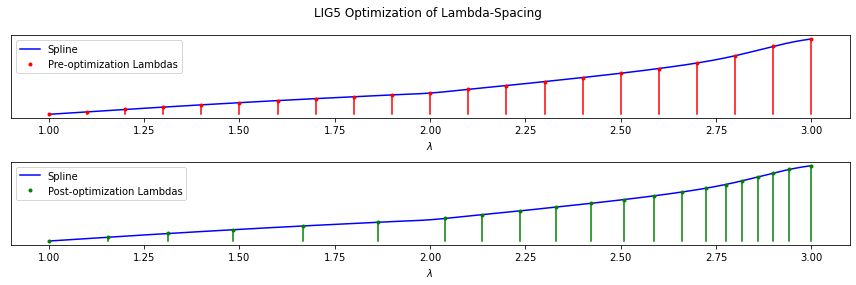

restraint-lambdas    = 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
coul-lambdas    = 0.0000 0.1539 0.3132 0.4830 0.6665 0.8637 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
vdw-lambdas     = 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0402 0.1359 0.2357 0.3296 0.4212 0.5081 0.5877 0.6600 0.7223 0.7747 0.8189 0.8589 0.8985 0.9419 1.0000

################### Processing RL/pre-opt/RUN7 ###################


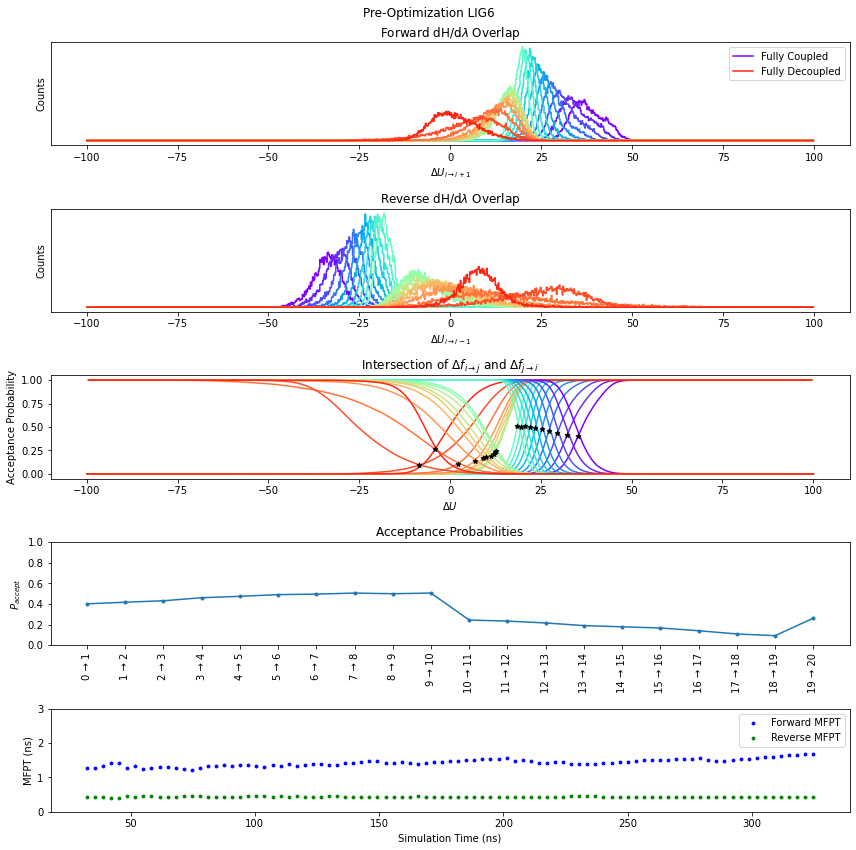

step 0 del_lambdas 1.5060450964353764e-05
Tolerance has been reached after 41729 steps.
            del_lambdas = 9.9962366426726e-14 < tol = 1e-13


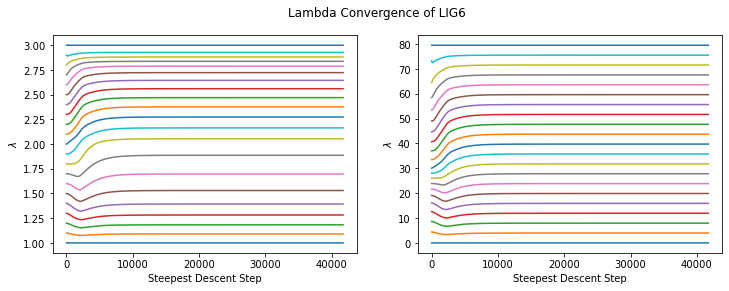

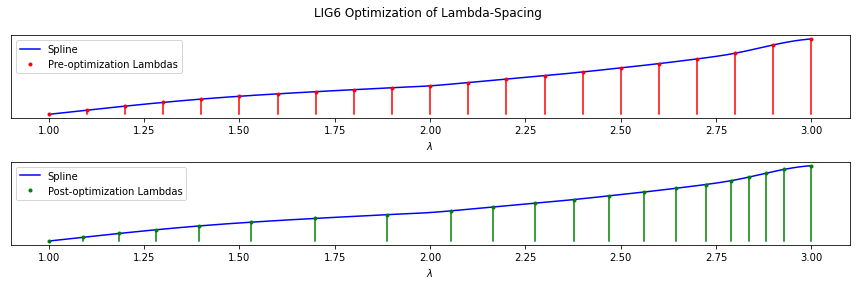

restraint-lambdas    = 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
coul-lambdas    = 0.0000 0.0903 0.1831 0.2822 0.3935 0.5302 0.6975 0.8867 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
vdw-lambdas     = 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0535 0.1637 0.2740 0.3763 0.4700 0.5602 0.6448 0.7228 0.7883 0.8373 0.8811 0.9277 1.0000



In [2]:
# usage for functions defined above (opt.py)

# Let's optimize our lambda schedule based on initial simulations with linearly spaced lambdas
cal_type = 'absolute'
frames_to_use = 10000000 # over-estimating number of dhdl entries uses all
save_plots = False # False for show plots
# if use states is not defined, we use all states in dhdl
use_states = range(10,31)
for x,run in enumerate([0,3,4,5,6,7]):
    path = f'RL/pre-opt/RUN{run}'
    mdpfile      = f'{path}/prod.mdp'
    dhdl_xvgfile = f'{path}/dhdl.xvg'
    
    print(f'################### Processing {path} ###################')
    
    if cal_type == 'absolute':
        coul_lambdas, vdw_lambdas, restraint_lambdas = get_coul_vdW_lambdas(mdpfile)
        lambdas = restraint_lambdas + coul_lambdas + vdw_lambdas
        thermo_states, dhdl = get_dhdl_data(dhdl_xvgfile, frames=frames_to_use)

    lambdas = [lambdas[x] for x in use_states]
    name = f'Pre-Optimization LIG{x+1}' # used for plot titles
    sigmas, mfpt = estimate_sigmas(dhdl, thermo_states, use_states=use_states)

    name = f'LIG{x+1}' # used for plot titles
    coul, vdw, rest = opt_lambdas(sigmas, cal_type, nsteps=1000000, tol=1e-13,
      alpha=1e-5, max_del_lambda=1e-4)
    #np.save(f'{path}/lambdas.npy', [coul, vdw])

################### Processing RL/post-opt/RUN0 ###################


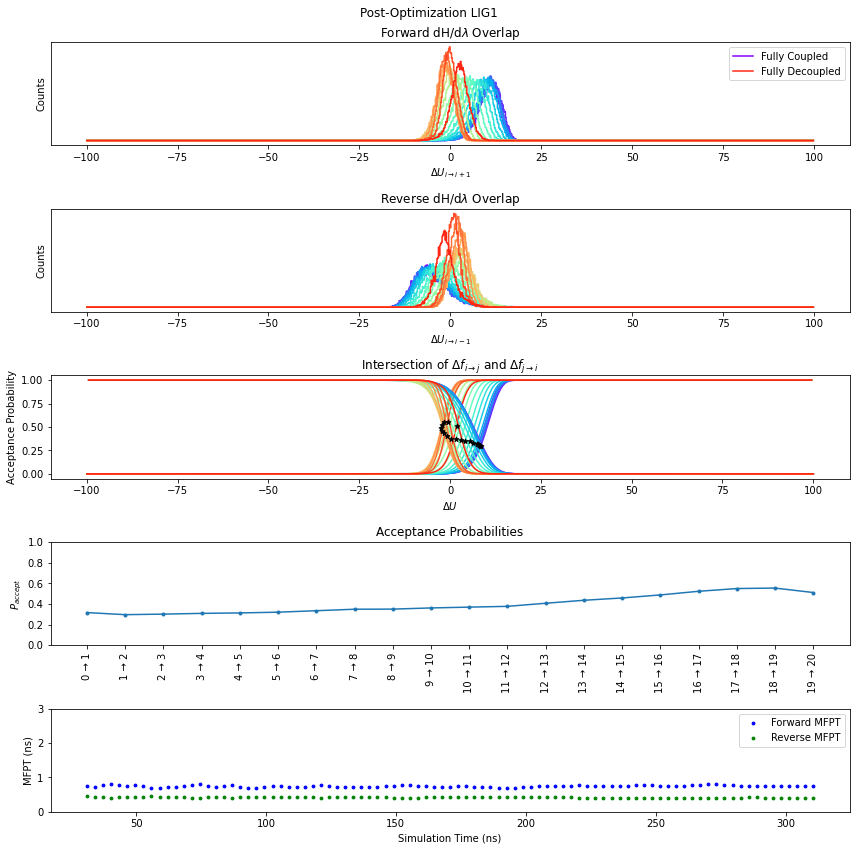

################### Processing RL/post-opt/RUN3 ###################


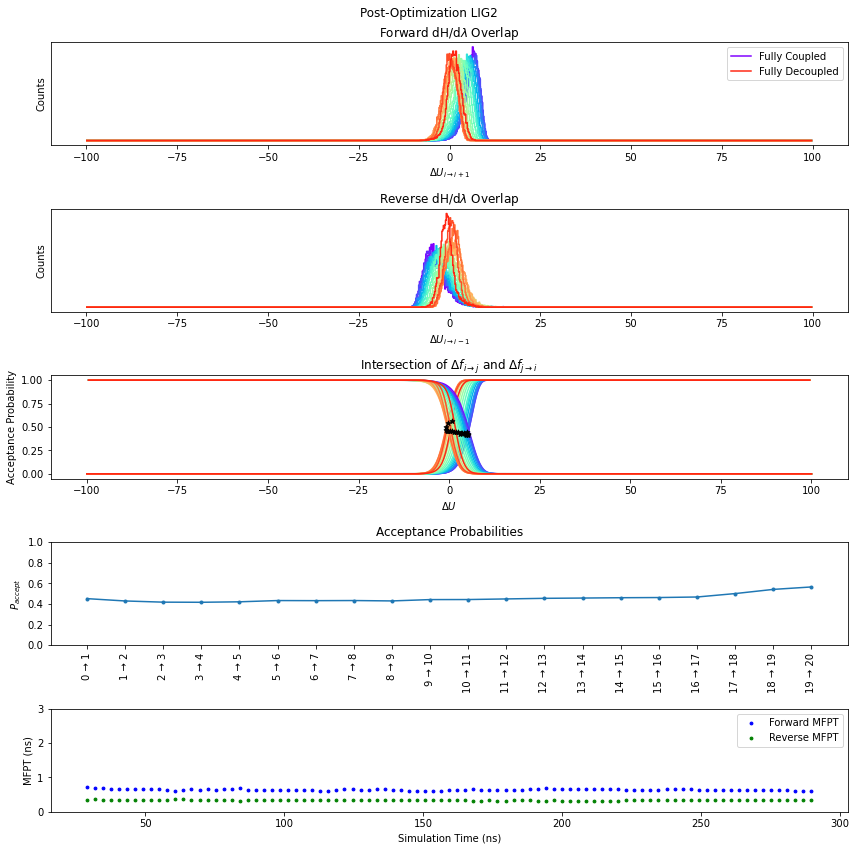

################### Processing RL/post-opt/RUN4 ###################


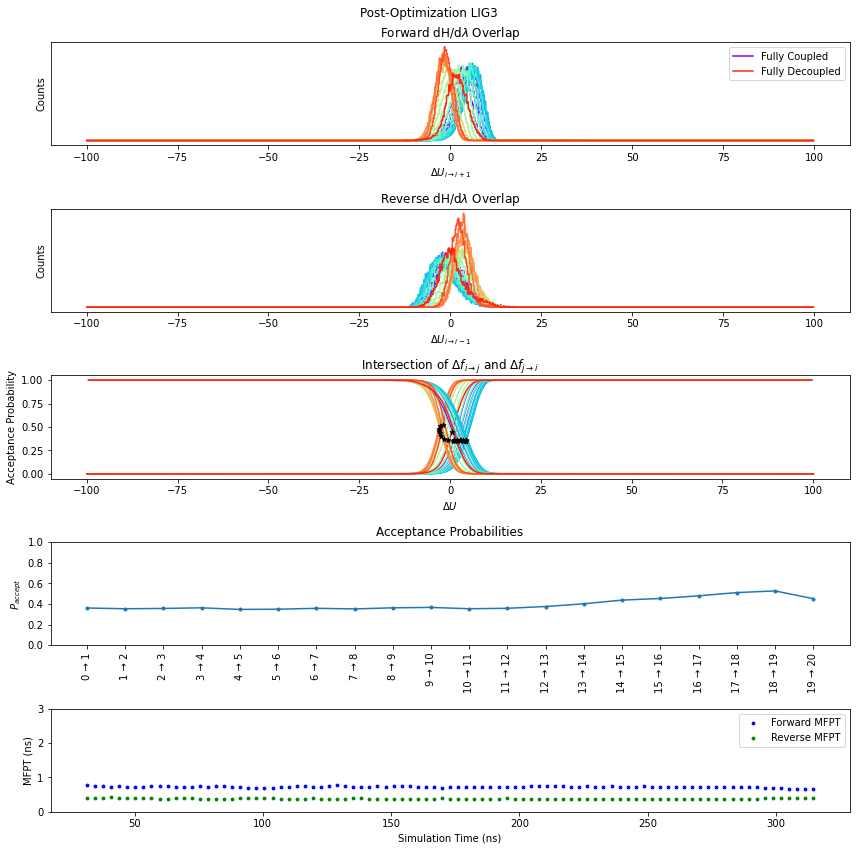

################### Processing RL/post-opt/RUN5 ###################


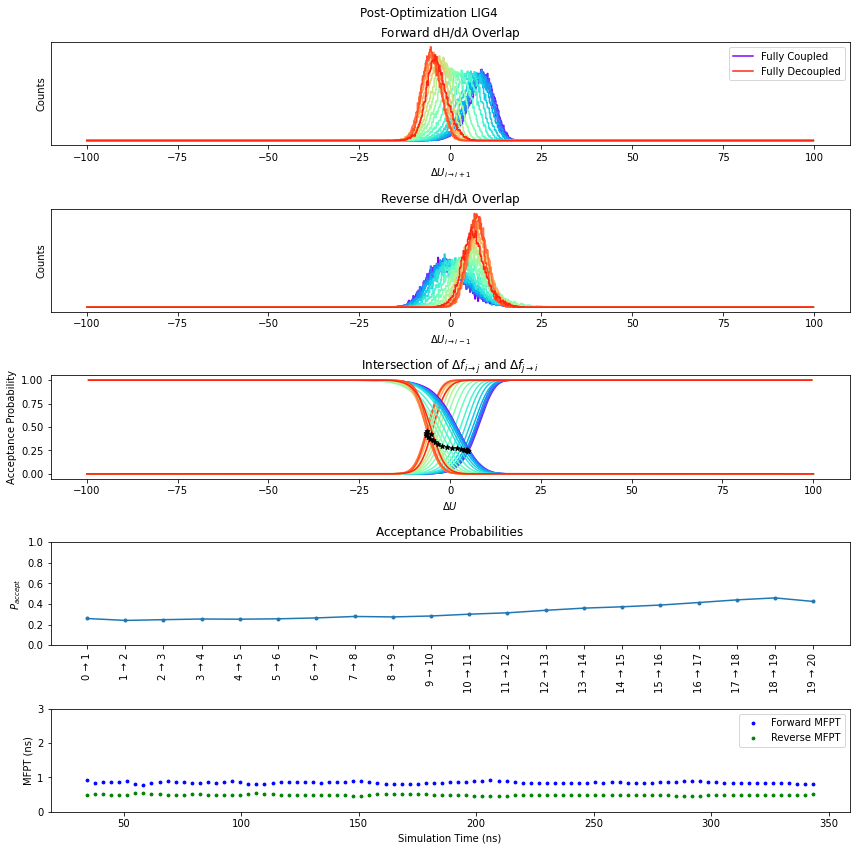

################### Processing RL/post-opt/RUN6 ###################


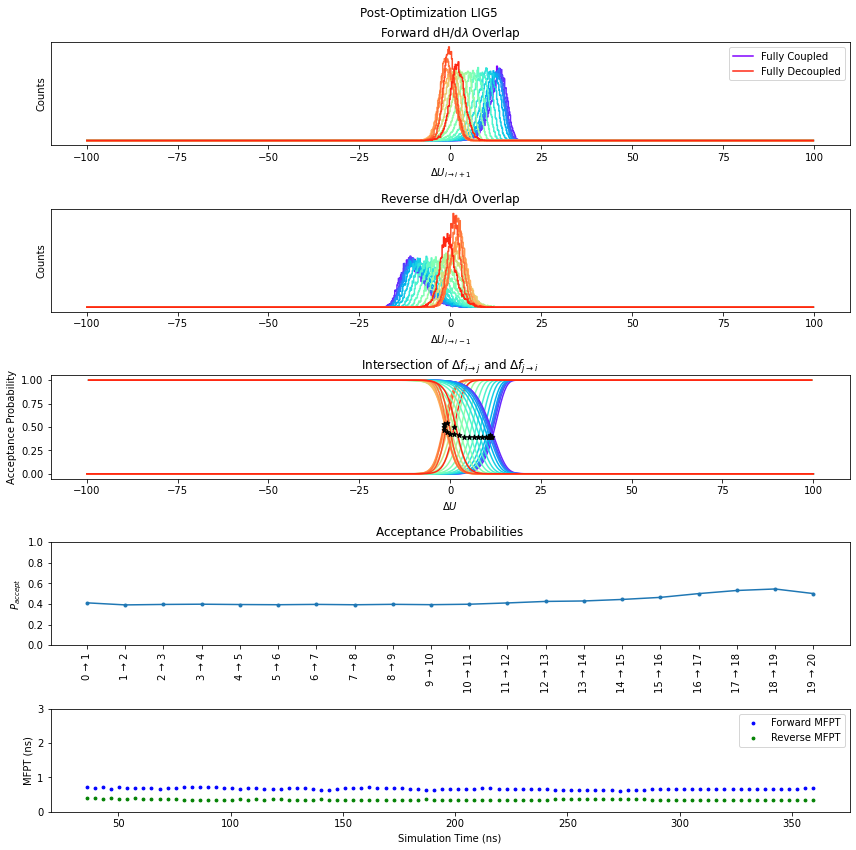

################### Processing RL/post-opt/RUN7 ###################


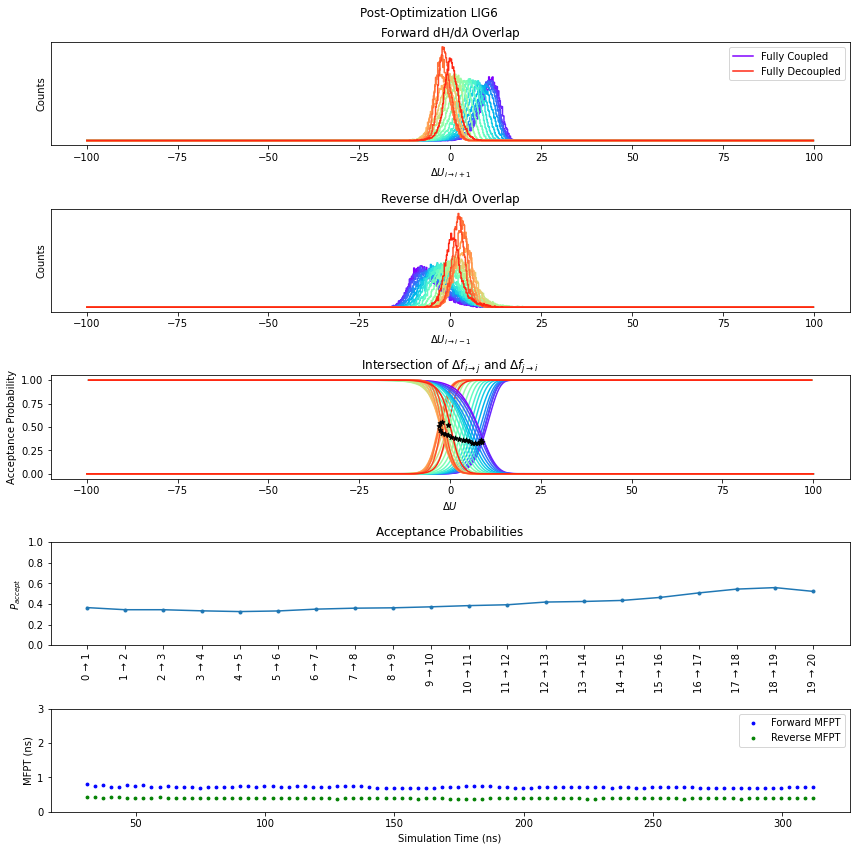

In [4]:
# Let's see how our optimized lambda schedules affects dH/dl overlap

cal_type = 'absolute'
frames_to_use = 10000000
# if use states is not defined, we use all states in dhdl
use_states = range(10,31)
for x,run in enumerate([0,3,4,5,6,7]):
    name = f'Post-Optimization LIG{x+1}' # used for plot titles
    path = f'RL/post-opt/RUN{run}'
    mdpfile      = f'{path}/prod.mdp'
    dhdl_xvgfile = f'{path}/dhdl.xvg'
    
    print(f'################### Processing {path} ###################')
    
    if cal_type == 'absolute':
        coul_lambdas, vdw_lambdas, restraint_lambdas = get_coul_vdW_lambdas(mdpfile)
        lambdas = restraint_lambdas + coul_lambdas + vdw_lambdas
        thermo_states, dhdl = get_dhdl_data(dhdl_xvgfile, frames=frames_to_use)

    lambdas = [lambdas[x] for x in use_states]
    sigmas, mfpt = estimate_sigmas(dhdl, thermo_states, use_states=use_states)



################### Processing ../round6/pre-opt/RUN0 ###################


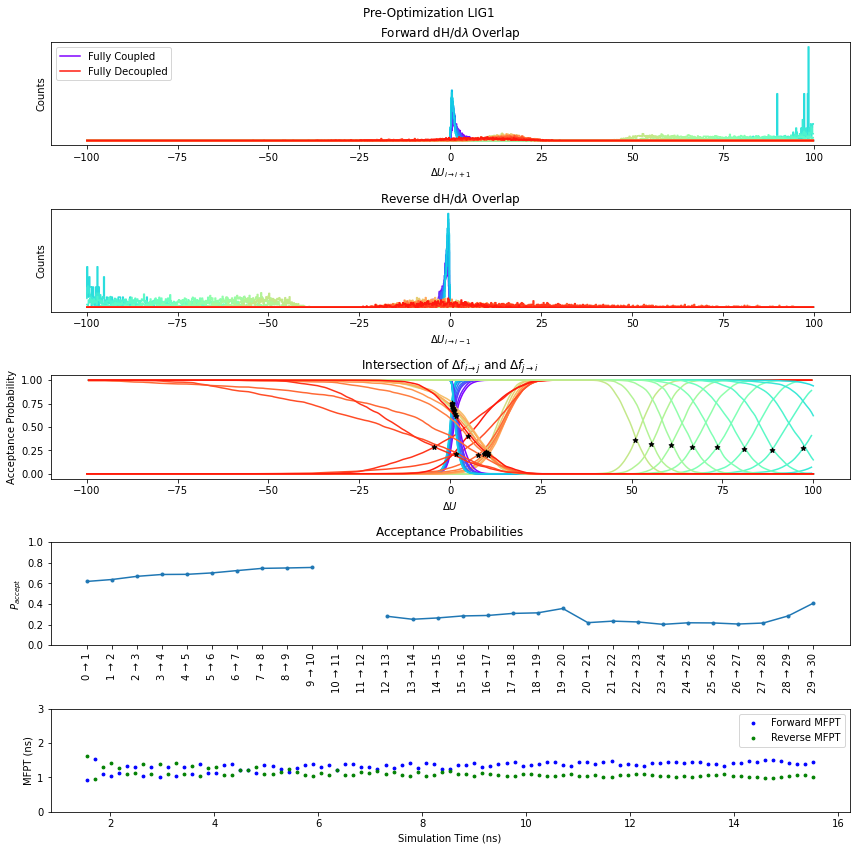

step 0 del_lambdas 1.040358732260789e-05
Tolerance has been reached after 55016 steps.
            del_lambdas = 9.99877980591191e-12 < tol = 1e-11


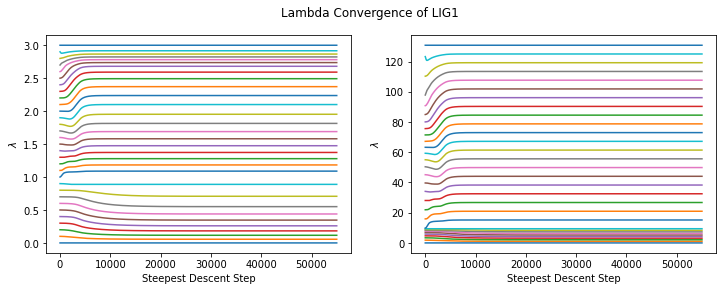

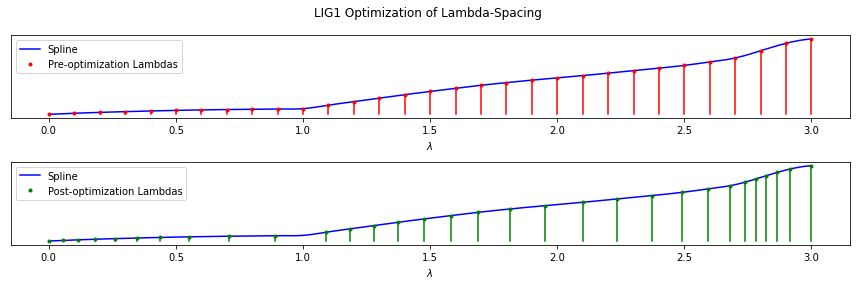

restraint-lambdas    = 0.0000 0.0556 0.1158 0.1825 0.2595 0.3460 0.4391 0.5505 0.7077 0.8886 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
coul-lambdas    = 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0895 0.1834 0.2786 0.3729 0.4751 0.5807 0.6895 0.8138 0.9524 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
vdw-lambdas     = 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.1000 0.2367 0.3716 0.4924 0.5920 0.6806 0.7367 0.7809 0.8227 0.8662 0.9162 1.0000



In [6]:
# usage for functions defined above (opt.py)

# Let's optimize our lambda schedule based on initial simulations with linearly spaced lambdas
cal_type = 'absolute'
frames_to_use = 10000000 # over-estimating number of dhdl entries uses all
save_plots = False # False for show plots
# if use states is not defined, we use all states in dhdl
#use_states = range(31) #range(10,31)
use_states = 0
for x,run in enumerate([0]):
    path = f'../round6/pre-opt/RUN{run}'
    mdpfile      = f'{path}/prod.mdp'
    dhdl_xvgfile = f'{path}/dhdl.xvg'
    
    print(f'################### Processing {path} ###################')
    

    if cal_type == 'absolute':
        coul_lambdas, vdw_lambdas, restraint_lambdas = get_coul_vdW_lambdas(mdpfile)
        lambdas = restraint_lambdas + coul_lambdas + vdw_lambdas
        thermo_states, dhdl = get_dhdl_data(dhdl_xvgfile, frames=frames_to_use)

    #lambdas = [lambdas[x] for x in use_states]
    name = f'Pre-Optimization LIG{x+1}' # used for plot titles
    sigmas, mfpt = estimate_sigmas(dhdl, thermo_states, use_states=use_states)

    name = f'LIG{x+1}' # used for plot titles
    coul, vdw, rest = opt_lambdas(sigmas, cal_type, nsteps=1000000, tol=1e-11,
      alpha=1e-5, max_del_lambda=1e-4)
    #np.save(f'{path}/lambdas.npy', [coul, vdw])

################### Processing ../round5/L/pre-opt/RUN0 ###################


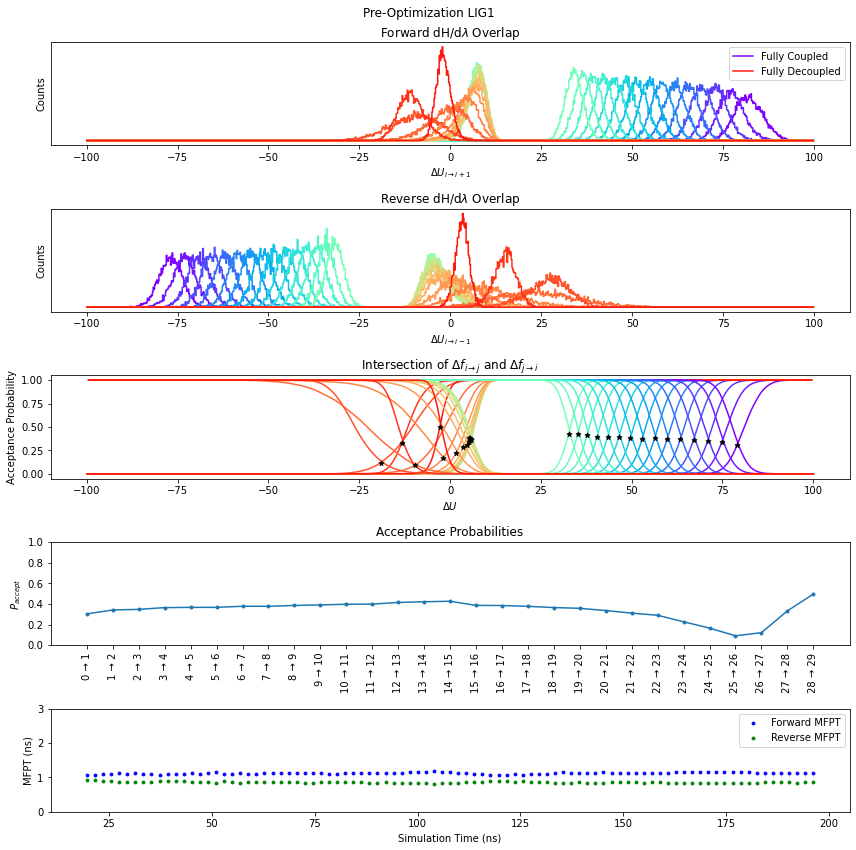

################### Processing ../round5/L/pre-opt/RUN3 ###################


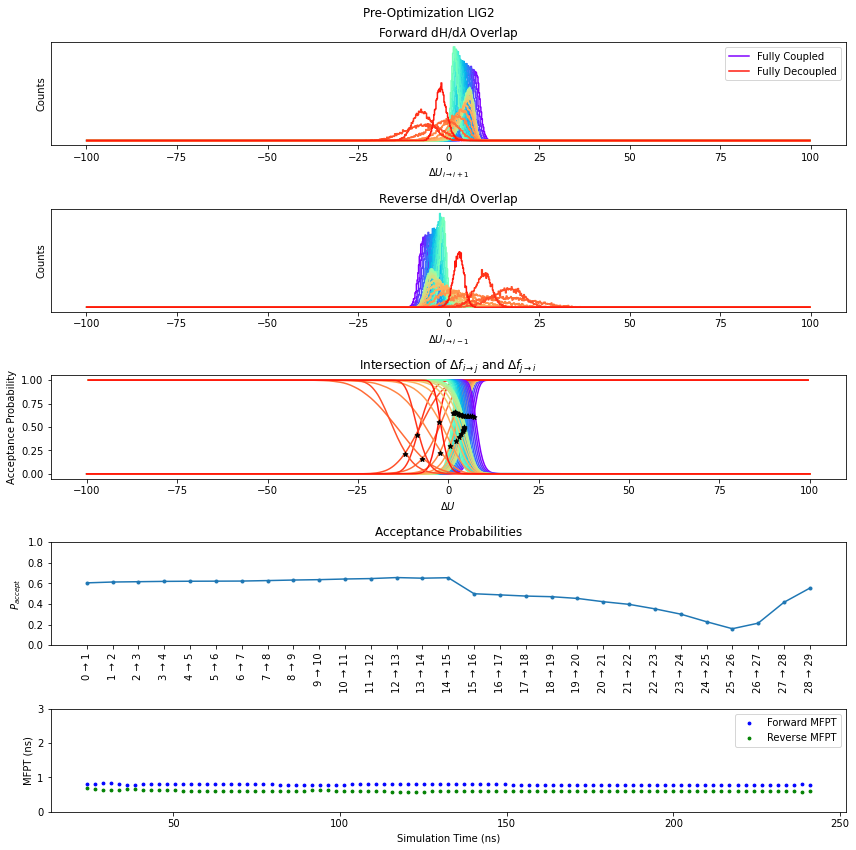

################### Processing ../round5/L/pre-opt/RUN4 ###################


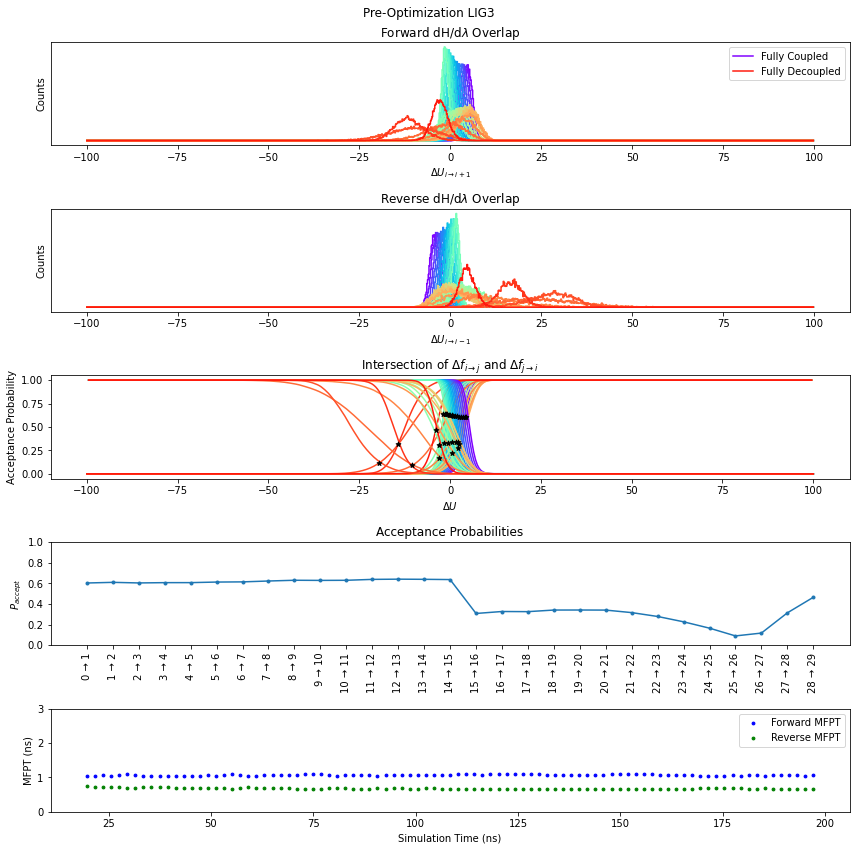

################### Processing ../round5/L/pre-opt/RUN5 ###################


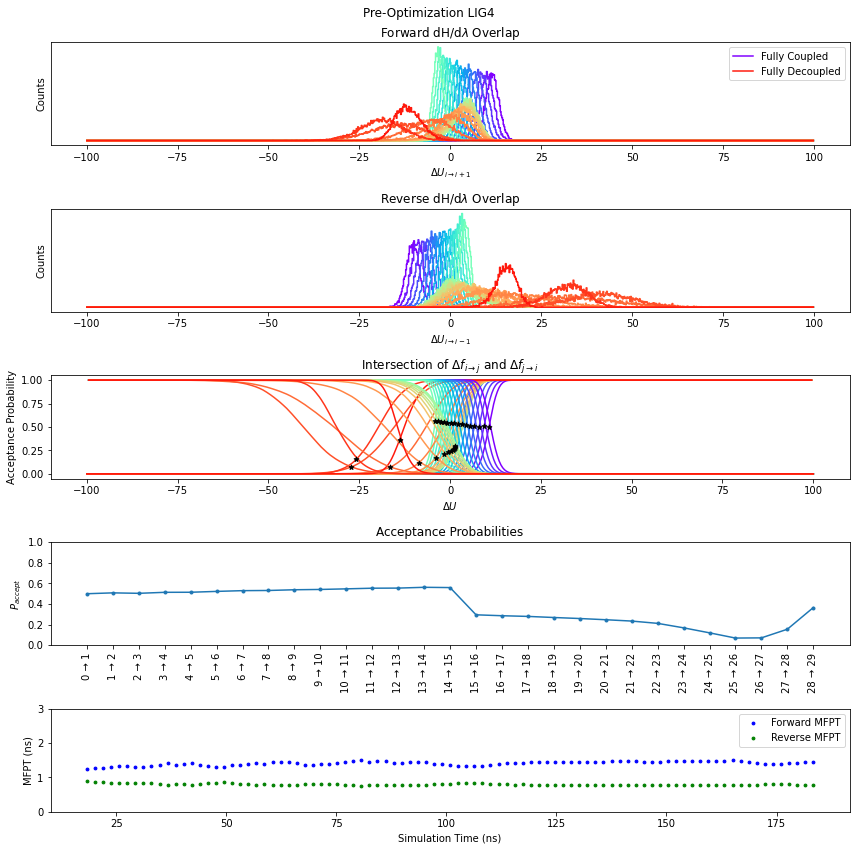

################### Processing ../round5/L/pre-opt/RUN6 ###################


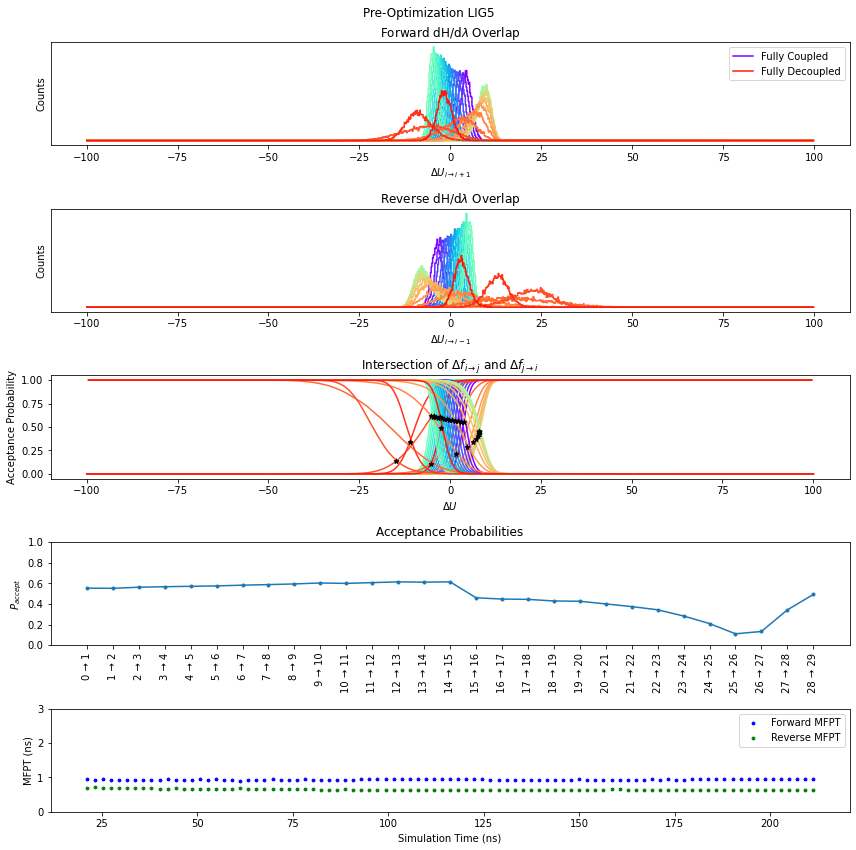

################### Processing ../round5/L/pre-opt/RUN7 ###################


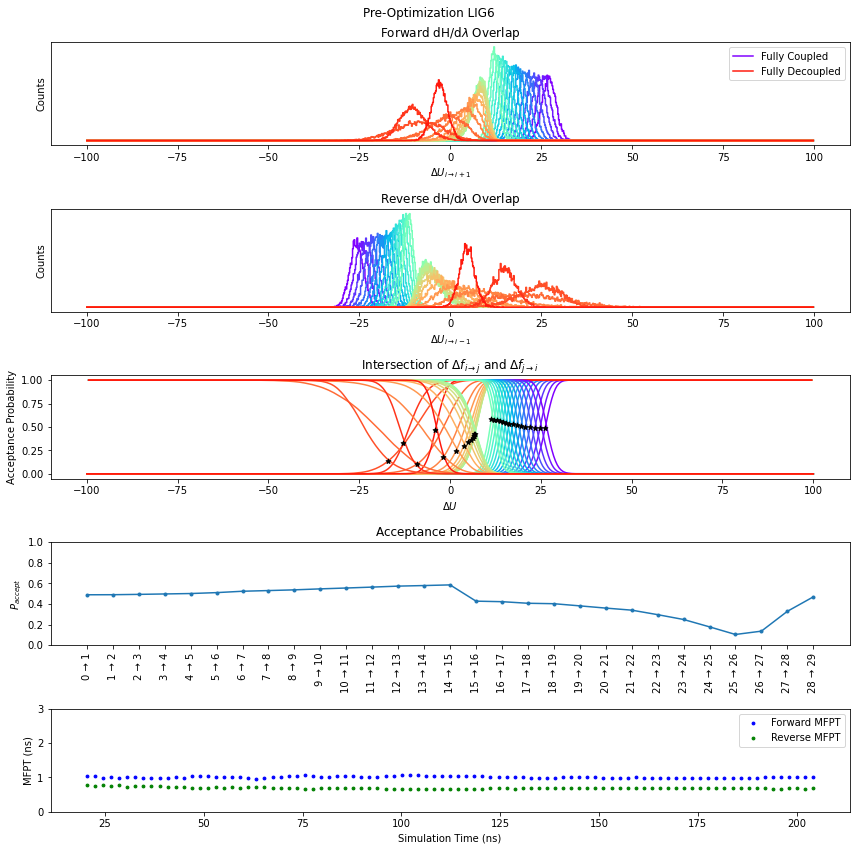

In [8]:
# Let's look at pre-optimized ligand-only simulations
cal_type = 'absolute'
frames_to_use = 10000000 # over-estimating number of dhdl entries uses all
save_plots = False # False for show plots
# if use states is not defined, we use all states in dhdl
#use_states = range(31) #range(10,31)
use_states = 0 # 0 for all
for x,run in enumerate([0,3,4,5,6,7]):
    path = f'L/pre-opt/RUN{run}'
    mdpfile      = f'{path}/prod.mdp'
    dhdl_xvgfile = f'{path}/dhdl.xvg'
    
    print(f'################### Processing {path} ###################')
    

    if cal_type == 'absolute':
        coul_lambdas, vdw_lambdas, restraint_lambdas = get_coul_vdW_lambdas(mdpfile)
        lambdas = restraint_lambdas + coul_lambdas + vdw_lambdas
        thermo_states, dhdl = get_dhdl_data(dhdl_xvgfile, frames=frames_to_use)

    #lambdas = [lambdas[x] for x in use_states]
    name = f'Pre-Optimization LIG{x+1}' # used for plot titles
    sigmas, mfpt = estimate_sigmas(dhdl, thermo_states, use_states=use_states)


################### Processing L/post-opt/RUN0 ###################


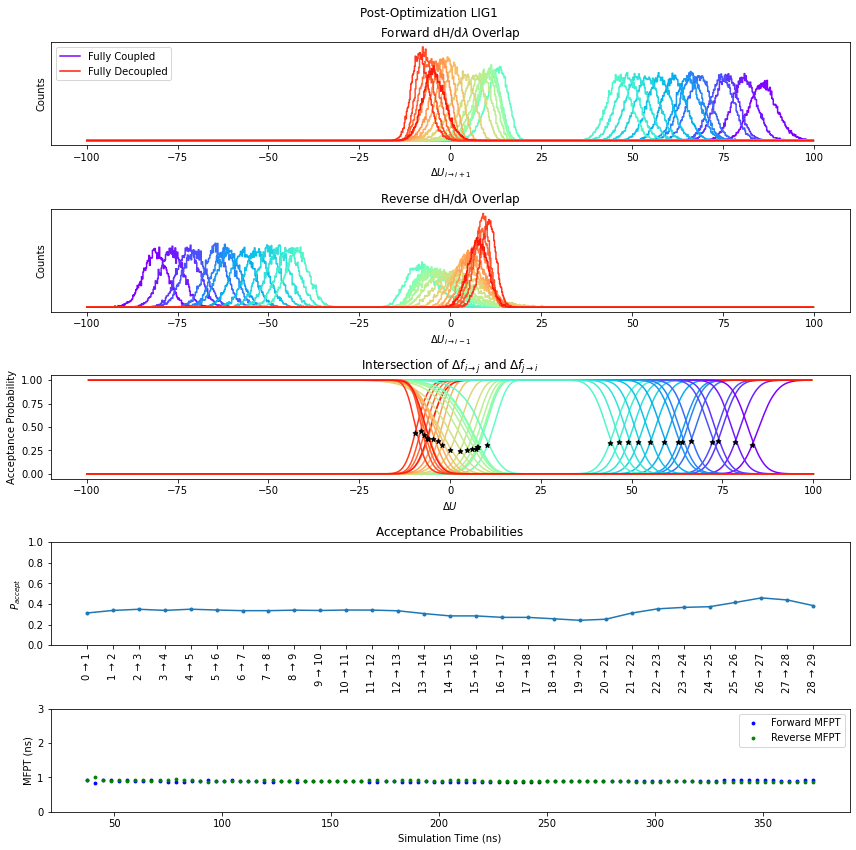

################### Processing L/post-opt/RUN3 ###################


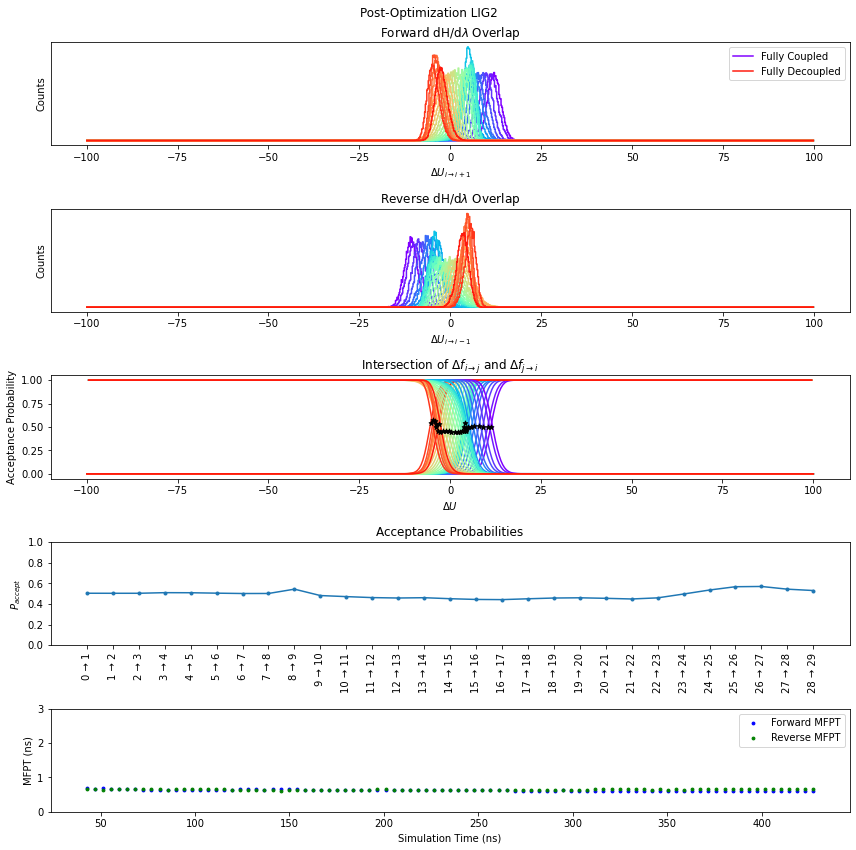

################### Processing L/post-opt/RUN4 ###################


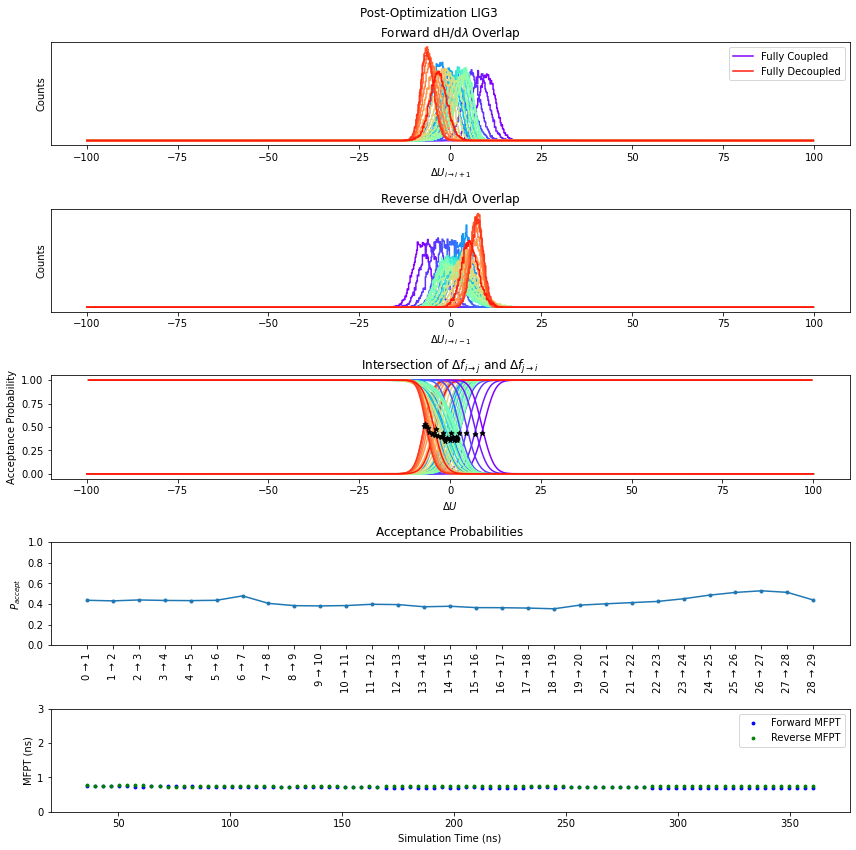

################### Processing L/post-opt/RUN5 ###################


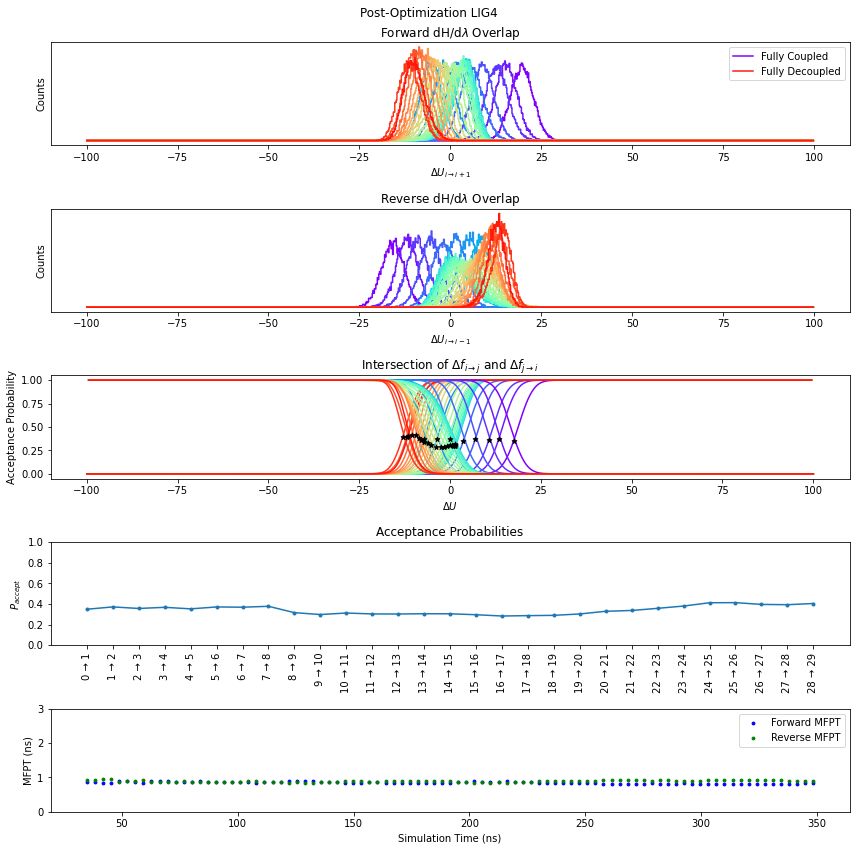

################### Processing L/post-opt/RUN6 ###################


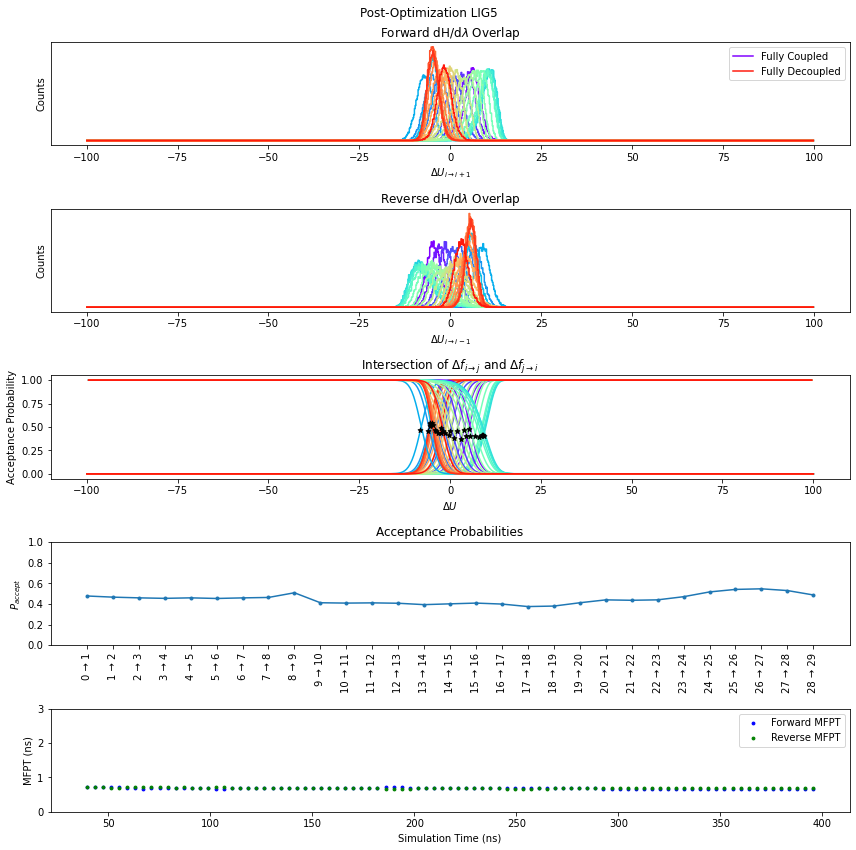

################### Processing L/post-opt/RUN7 ###################


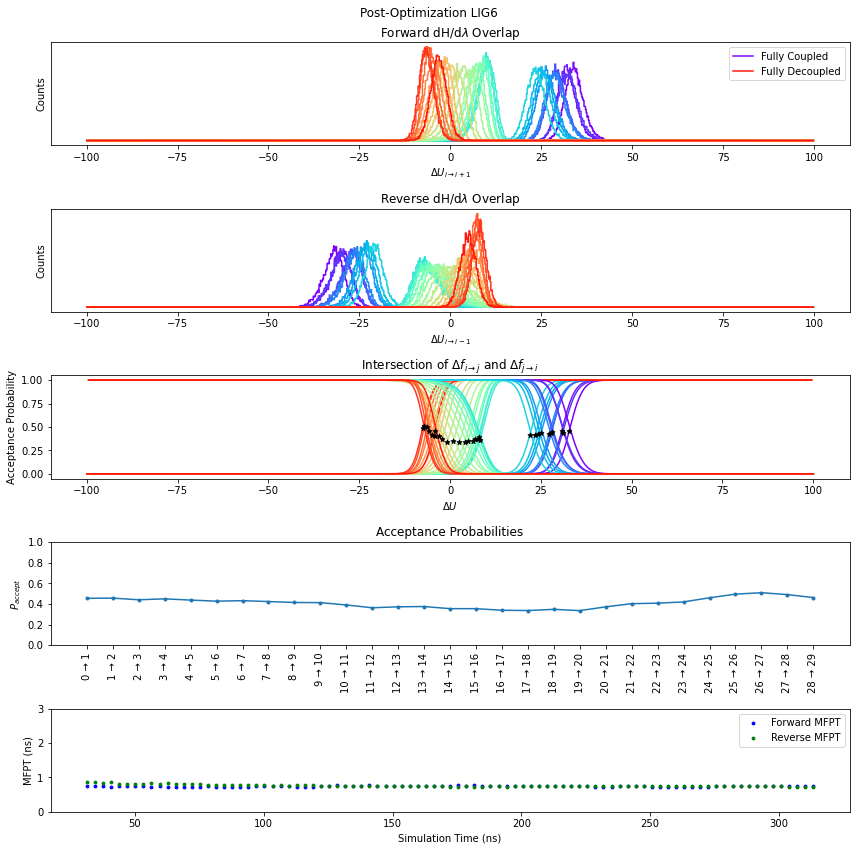

In [9]:
# Let's look at optimized ligand-only simulations
cal_type = 'absolute'
frames_to_use = 10000000 # over-estimating number of dhdl entries uses all
save_plots = False # False for show plots
# if use states is not defined, we use all states in dhdl
#use_states = range(31) #range(10,31)
use_states = 0 # 0 for all
for x,run in enumerate([0,3,4,5,6,7]):
    path = f'L/post-opt/RUN{run}'
    mdpfile      = f'{path}/prod.mdp'
    dhdl_xvgfile = f'{path}/dhdl.xvg'
    
    print(f'################### Processing {path} ###################')
    

    if cal_type == 'absolute':
        coul_lambdas, vdw_lambdas, restraint_lambdas = get_coul_vdW_lambdas(mdpfile)
        lambdas = restraint_lambdas + coul_lambdas + vdw_lambdas
        thermo_states, dhdl = get_dhdl_data(dhdl_xvgfile, frames=frames_to_use)

    #lambdas = [lambdas[x] for x in use_states]
    name = f'Post-Optimization LIG{x+1}' # used for plot titles
    sigmas, mfpt = estimate_sigmas(dhdl, thermo_states, use_states=use_states)

In [6]:
opt_tau, unopt_tau = [],[]
system_type = 'RL'
opt_level = 'post-opt'
for i in [3,4,5,6,7]:
    try:
      with open(f'plots/tau_{system_type}_{opt_level}_RUN{i}_100.txt') as f:
          lines = f.readlines()
          opt_tau.append([i] + [float(x.split()[1])/200 for x in lines])
      with open(f'plots/tau_{system_type}_pre-opt_RUN{i}_100.txt') as f:
          lines = f.readlines()
          unopt_tau.append([i] + [float(x.split()[1])/200 for x in lines])
    except Exception as e:
        continue
#print(opt_tau)
#print(unopt_tau)

fig = plt.figure(figsize=(10,5))
ax = plt.subplot(121)

ax.scatter([x[0] for x in unopt_tau],[x[1] for x in unopt_tau], c='r', label='pre-opt τ_(1->N)')
ax.scatter([x[0] for x in opt_tau],[x[1] for x in opt_tau], c='g', label='post-opt τ_(1->N)')
ax.scatter([x[0] for x in unopt_tau],[x[2] for x in unopt_tau], c='orange', label='pre-opt τ_(N->1)')
ax.scatter([x[0] for x in opt_tau],[x[2] for x in opt_tau], c='b', label='post-opt τ_(N->1)')

plt.xticks([3,4,5,6,7],['I18','I31','NUT','YIN','K23'])
plt.xlabel('Receptor-Ligand Systems')
plt.ylabel('τ (ns)')
# Shrink current axis by 20%
#box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.title('Mean First Passage Time (MFPT) Optimization')
# Put a legend to the right of the current axis
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='upper right')
ax2 = plt.subplot(122)

ax2.scatter([x[0] for x in opt_tau], [abs(unopt_tau[x][1]-unopt_tau[x][2])
     for x in range(len(opt_tau))], c='r', label='pre-opt Δτ')
ax2.scatter([x[0] for x in opt_tau], [abs(opt_tau[x][1]-opt_tau[x][2])
     for x in range(len(opt_tau))], c='g', label='post-opt Δτ')
ax2.legend(loc='best')

plt.xticks([3,4,5,6,7],['I18','I31','NUT','YIN','K23'])
plt.title('Optimization of Forward-Reverse MFPT')
plt.xlabel('Receptor-Ligand Systems')
plt.ylabel('Δτ (ns)')

plt.tight_layout()
#plt.show()
plt.savefig(f'plots/MFPT.pdf')
plt.close()

ligands = ['I18','I31','NUT','YIN','K23']
for i in [3,4,5,6,7]:

    if os.path.exists(f'plots/tau_{system_type}_pre-opt_RUN{i}_100.txt') and os.path.exists(
        f'plots/tau_{system_type}_{opt_level}_RUN{i}_100.txt'):
        taus = [] # pre-opt
        plt.figure(figsize=(10,3))
        plt.ylabel('MFPT (ns)')
        for j in range(1,101):
            if os.path.exists(f'plots/tau_{system_type}_pre-opt_RUN{i}_{j}.txt'):
                with open(f'plots/tau_{system_type}_pre-opt_RUN{i}_{j}.txt') as f:
                    lines = f.readlines()
                taus.append([j] + [float(x.split()[1])/200 for x in lines])
        taus = np.asarray(taus)        
        plt.subplot(2,1,1)
        plt.scatter(taus[:,0],taus[:,1], color='r', s=5)
        plt.scatter(taus[:,0],taus[:,2], color='orange', s=5)
        plt.title(f'{ligands[i-3]} Pre-Optimization Mean First Passage Times (ns)')
        plt.ylabel('τ (ns)')
        
        taus = [] # post-opt
        for j in range(1,101):
            if os.path.exists(f'plots/tau_{system_type}_{opt_level}_RUN{i}_{j}.txt'):
                with open(f'plots/tau_{system_type}_{opt_level}_RUN{i}_{j}.txt') as f:
                    lines = f.readlines()
                taus.append([j] + [float(x.split()[1])/200 for x in lines])
        taus = np.asarray(taus)        
        plt.subplot(2,1,2)
        plt.scatter(taus[:,0],taus[:,1], color='g', s=5)
        plt.scatter(taus[:,0],taus[:,2], color='b', s=5)

        plt.xlabel('Trajectory Progress (%)')
        plt.ylabel('τ (ns)')
        plt.title(f'{ligands[i-3]} Post-Optimization Mean First Passage Times (ns)')
        plt.tight_layout()
        print(f'MFPT_convergence_RUN{i}.png')
        plt.show()
        #plt.savefig(f'plots/MFPT_convergence_RUN{i}.png')
        plt.close()

1378
1626
1166
1442


/tmp/ipykernel_26169/2982033426.py:33: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


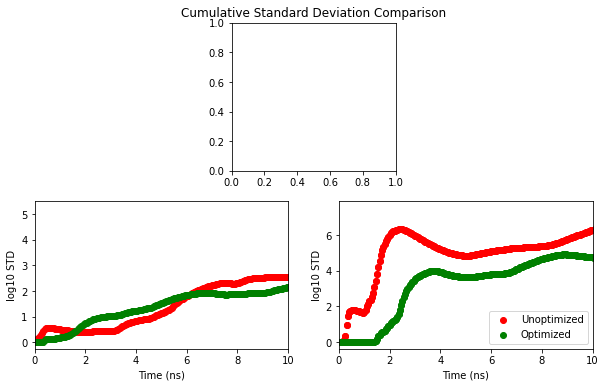

In [23]:
import numpy as np
from matplotlib import pyplot as plt
# cumulative variance comparison
plt.figure(figsize=(10,6))
for run in range(4,8):
    g_unopt = np.load(f'RL/pre-opt/RUN{run}/feb.npy')
    g_opt = np.load(f'RL/post-opt/RUN{run}/feb.npy')
    inc_unopt = np.load(f'RL/pre-opt/RUN{run}/inc.npy')
    inc_opt = np.load(f'RL/post-opt/RUN{run}/inc.npy')
    for z in range(len(inc_unopt)):
        if inc_unopt[z] < 0.8:
            print(z);break

    cv_unopt, cv_opt = [],[]

    for i in range(z,min(len(g_unopt),len(g_opt))):
        cv_unopt.append(np.std(g_unopt[:,-1][z:i]))
        cv_opt.append(np.std(g_opt[:,-1][z:i])) # [:,-1]
    plt.subplot(2,2,run-3)
    x_values = [x*0.05 for x in range(len(cv_opt))]
    if run == 7:
        plt.scatter(x_values,cv_unopt,color='red', label='Unoptimized')
        plt.scatter(x_values,cv_opt, color='green', label='Optimized')
        plt.legend()
    plt.scatter(x_values,cv_unopt,color='red')
    plt.scatter(x_values,cv_opt, color='green')
    #plt.yscale('log')
    plt.ylabel('log10 STD')
    plt.xlabel('Time (ns)')
    plt.xlim(0,10)
plt.subplot(2,3,2)
plt.title('Cumulative Standard Deviation Comparison')
plt.tight_layout()

/Users/sizhang/anaconda3/envs/py36/lib/python3.6/site-packages/pyemma/util/log.py:65: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  D = yaml.load(f2)
/Users/sizhang/anaconda3/envs/py36/lib/python3.6/site-packages/pyemma/__init__.py:130: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.7, you have 2.5.4.
  .format(latest=latest, current=current), category=UserWarning)


tau_(1->N)= 13163.702577991766
tau_(N->1)= 13626.172265652474


In [ ]:
#opt = [-8.9,3.7,0.77,-8.31,-2.82,-9.95,4.56] # pre-CA restraints
opt = [-8.63, -5.38, -4.52, -6.38, -9.76, -8.61, -2.59]
unopt = [-9.32,4.64,5.7,-7.67,1.02,-3.23,2.85]
exp = [86,3900,26000,20000,200,1100,1700]
plt.scatter(opt,[np.log10(x*10**-9) for x in exp])
plt.plot([-10,-3],[-10,-3])
plt.xlabel('Computed log10 Kd')
plt.ylabel('log10 IC50')
plt.title('Optimized Lambdas')
plt.show()